# Weighted gene correlation network analysis
Weighted gene correlation network analysis (WGCNA) is a package that allows us to cluster our transcripts into modules by similar gene expression profiles. From there we can correlate our modules with the metadata from the experiment, or in this case our treatment groups. The data presented in this notebook are from the *Astrangia poculata* larvae bacteria exposure experiment where we have three treatment groups control, pathogen (*Vibrio corallilyticus* - RE22), and probiotic (*Phaeobacter inhibens* - S4).

#### WGCNA reference
Langfelder, P., & Horvath, S. (2008). WGCNA: an R package for weighted correlation network analysis. BMC bioinformatics, 9, 1-13.

#### Manuscript reference
Borbee, E.M., Changsut, I.V., Bernabe, K., Schickle, A., Nelson, D., Sharp, K.H., and Fuess, L.E. (2025) Coral larvae have unique transcriptomic responses to pathogenic and probiotic bacteria. *In prep*.

## Contents
1. [General setup](#1)
2. [Import data](#2)
3. [Format data](#3)
4. [Check for samples with missing values](#4)
5. [Sample clustering and filtering](#5)
6. [Create metadata dataframe analgous to expression data](#6)
7. [Recluster samples with metadata](#7)
8. [Scale-free topology fitting](#8)
9. [Construct network](#9)
10. [Plot module dendrogram](#10)
11. [Calculate metadata module correlations](#11)
12. [Calculating functional enrichment in modules](#12)
13. [Enrichment by functional category plots](#13)
14. [Enrichment summary figure](#14)

<a id=1></a>
## 1. General setup
Here, we load packages necessary for the analysis, set our working directory, and set `stringsAsFactors` to FALSE.

In [69]:
library(WGCNA)
library(ggplot2)
library(dplyr)
library(reshape2)
library(ggpubr)
library(tidyr)
library(STRINGdb)
library(igraph)
library(patchwork)

In [70]:
setwd("~/Desktop/TXST/AstrangiaLarval_transcriptomics/WGCNA/")

In [71]:
options(stringsAsFactors = FALSE)

<a id=2></a>
## 2. Import data
Now we import our normalized count data and metadata files. The count data should be the normalized count output from DESeq2 and the metadata file should be a file containing sample IDs and the treatment group for each sample.

In [72]:
data <- read.table("normalizedreads.csv", sep = ",", header = TRUE, row.names = 1)
names(data)
dim(data)

[1] "EB001" "EB002" "EB003" "EB004" "EB005" "EB006" "EB007" "EB008" "EB009"
[10] "EB010" "EB011" "EB012" "EB013" "EB014" "EB015"

[1] 18327    15

In [73]:
metadata <- read.csv("Astrangia_LarvalExp_MetaData.csv")
names(metadata)

[1] "sampleID"    "sampleNum"   "treatment"   "timeStarted" "timeEnded"

<a id=3></a>
## 3. Format data
Here, we make sure the count data and metadata are properly formatted for the rest of the script. The first block of code transposes the count data so that rows are samples and columns are transcript IDs, and the rownames are the sample IDs. 

The second block of code formats the metadata to only the variables of interest, in this case treatment group, and the third block uses the `binarizeCategoricalColumns()` command to convert the categorical variables to 1 or 0 for the two groups being compared or NA for the group to omit for each possible pairwise comparison (i.e. pathogen vs control, probiotic vs pathogen, and probiotic vs control).

In [74]:
counts_trans <- as.data.frame(t(data))

In [75]:
metadata_filtered <- metadata[,c(1,3)]
names(metadata_filtered)

[1] "sampleID"  "treatment"

In [76]:
metadata_binary <- binarizeCategoricalColumns(metadata_filtered$treatment, includePairwise = TRUE, includeLevelVsAll = FALSE)
rownames(metadata_binary) <- metadata$sampleID
head(metadata_binary)

data.RE22.vs.Control data.S4.vs.Control data.S4.vs.RE22
EB001 0                     0                 NA             
EB007 0                     0                 NA             
EB011 0                     0                 NA             
EB014 0                     0                 NA             
EB013 0                     0                 NA             
EB003 1                    NA                  0

## 4. Check for samples with missing values
This portion of code specifically looks in the count file for transcripts that have 0s across all samples to filter them out and reduce data size.

In [77]:
missing_counts <- goodSamplesGenes(counts_trans, verbose = 3)
missing_counts$allOK
if (!missing_counts$allOK)
{
  # Optionally, print the gene and sample names that were removed:
  if (sum(!missing_counts$goodGenes)>0)
    printFlush(paste("Removing genes:", paste(names(counts_trans)[!missing_counts$goodGenes], collapse = ", ")));
  if (sum(!missing_counts$goodSamples)>0)
    printFlush(paste("Removing samples:", paste(rownames(counts_trans)[!missing_counts$goodSamples], collapse = ", ")));
  # Remove the offending genes and samples from the data:
  counts_trans = counts_trans[missing_counts$goodSamples, missing_counts$goodGenes]
}

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

Because the output says TRUE, we know all of our transcripts are good and we can proceed with the rest of the analysis.

<a id=5></a>
## 5. Sample clustering and filtering
Next, we visualized initial sample clsutering using dendrograms.

In [78]:
sampleTree = hclust(dist(counts_trans), method = "average");

In [79]:
sizeGrWindow(12,9)
par(cex = 0.6);
par(mar = c(0,4,2,0))

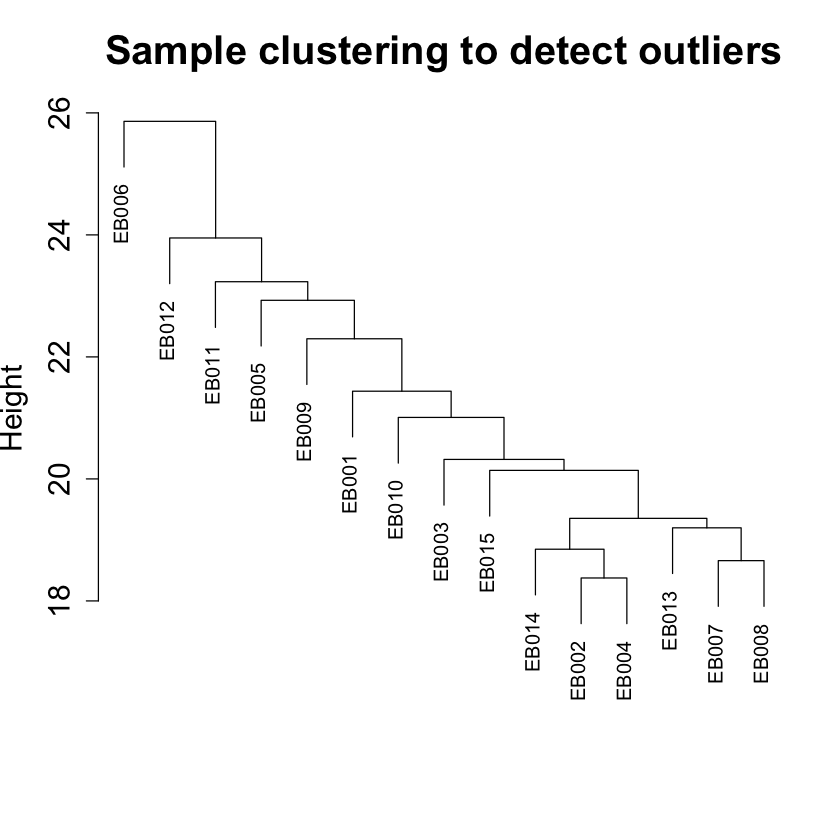

In [80]:
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", cex.lab = 1.5,
     cex.axis = 1.5, cex.main = 2)

The next lines of code, add lines to show cut heigh on the dendrogram.

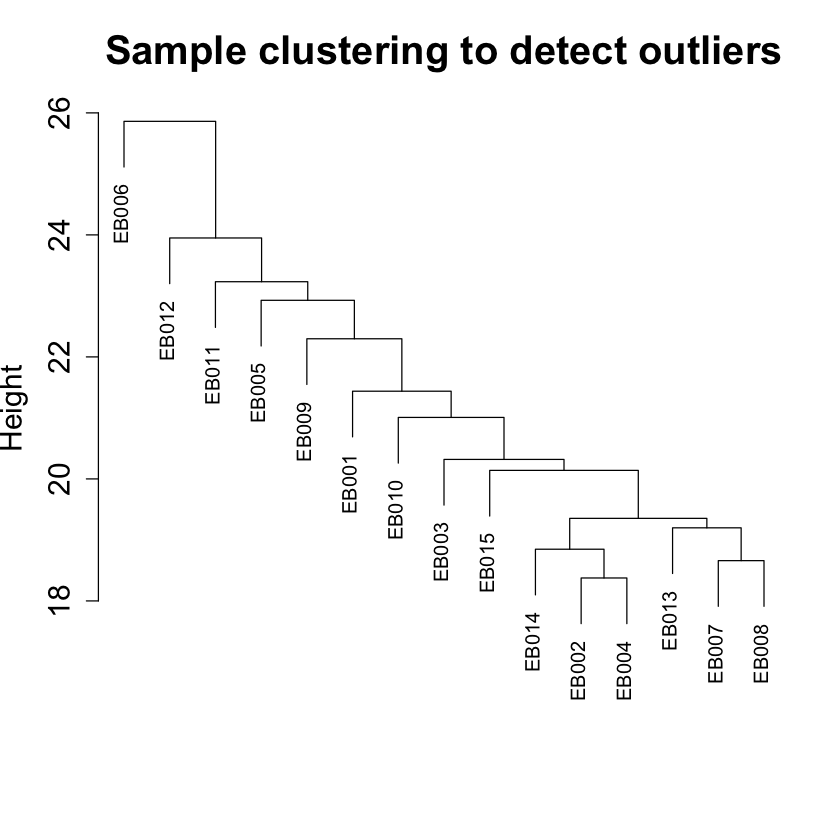

In [81]:
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", cex.lab = 1.5,
     cex.axis = 1.5, cex.main = 2)
abline(h = 15, col = "red");
abline(h = 30000, col = "red");

The next code will identify samples the fall under the cut lines and then filters the count dataframe to only include those samples. In the case of this dataset, we retain all samples.

In [82]:
clust <- cutreeStatic(sampleTree, cutHeight = 3000, minSize = 10)
table(clust)

clust
 1 
15 

In [83]:
keepSamples <- (clust==1)
dataExpr <- counts_trans[keepSamples, ]
nGenes <- ncol(dataExpr)
nSamples <- nrow(dataExpr)

<a id=6></a>
## 6. Create metadata dataframe analagous to expression data
Here, we are creating a metadata object that includes our original categorical terms in the same order and format as our expression dataframe.

In [84]:
samples <- rownames(counts_trans);
metadataRows <- match(samples, metadata_filtered$sampleID);
metadata_var <- as.data.frame(metadata_filtered[metadataRows, -1]);
rownames(metadata_var) <- metadata_filtered[metadataRows, 1];
collectGarbage();

In [85]:
head(metadata_var)

metadata_filtered[metadataRows, -1]
EB001 Control                            
EB002 RE22                               
EB003 RE22                               
EB004 RE22                               
EB005 RE22                               
EB006 S4

<a id=7></a> 
## 7. Recluster samples with metadata
Now, we will recluster our samples and plot a new dendrogram with the metadata as heatmap along the tips of the dendrogram.

In [86]:
sampleTree2 <- hclust(dist(counts_trans), method = "average")

In [87]:
metadata_var_num <- metadata_var %>% mutate(`metadata_filtered[metadataRows, -1]` = case_when(`metadata_filtered[metadataRows, -1]` == "RE22" ~ 1, 
                                                                                              `metadata_filtered[metadataRows, -1]` == "S4" ~ 2,
                                                                                              `metadata_filtered[metadataRows, -1]` == "Control" ~ 3))
metaColors <- numbers2colors(metadata_var_num, signed = FALSE);

In [88]:
metaColors <- numbers2colors(metadata_var_num, signed = FALSE);

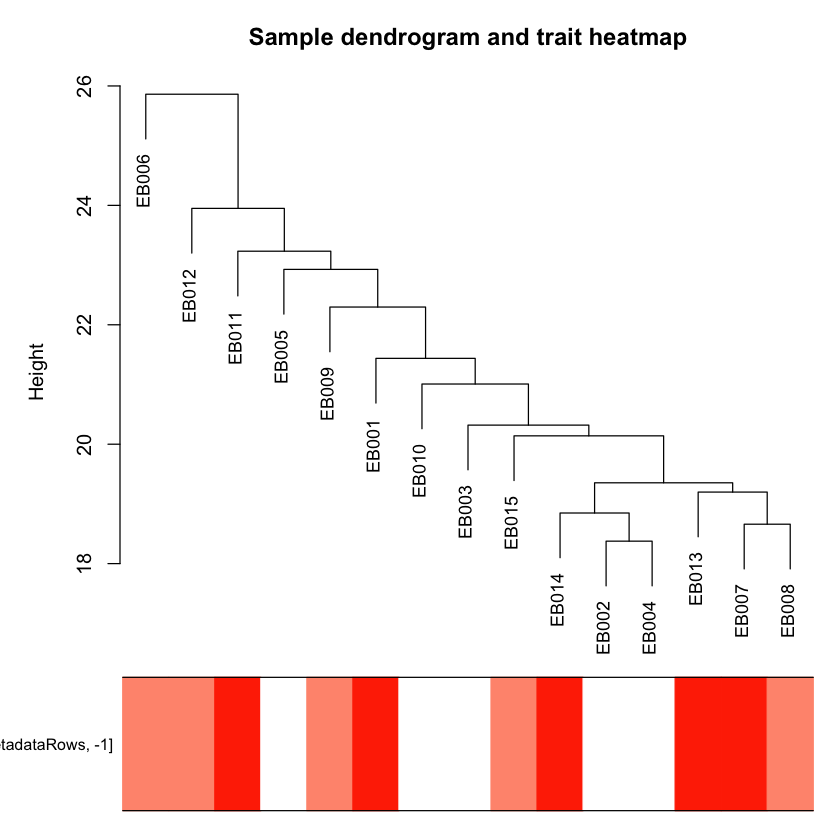

In [89]:
plotDendroAndColors(sampleTree2, metaColors,
                    groupLabels = names(metadata_var),
                    main = "Sample dendrogram and trait heatmap")

<a id=8 ></a>
## 8. Scale-free topology fitting
Following reclustering, we now run a scale-free topology fit on our data that begins with soft-thresholding which will tell us what power to select for running our network. We first start by picking a set of soft thresholding powers and calling the network topology analysis function. 

In [90]:
powers <- c(c(1:10), seq(from = 12, to=20, by=2))
sft <- pickSoftThreshold(counts_trans, powerVector = powers, verbose = 5)

pickSoftThreshold: will use block size 2441.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2441 of 18327
   ..working on genes 2442 through 4882 of 18327
   ..working on genes 4883 through 7323 of 18327
   ..working on genes 7324 through 9764 of 18327
   ..working on genes 9765 through 12205 of 18327
   ..working on genes 12206 through 14646 of 18327
   ..working on genes 14647 through 17087 of 18327
   ..working on genes 17088 through 18327 of 18327
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0326 -2.300          0.410  3970.0   4020.00   4510
2      2   0.4980 -7.780          0.720  1330.0   1330.00   1700
3      3   0.4730 -8.230          0.388   582.0    562.00    916
4      4   0.6150 -2.590          0.525   309.0    273.00    593
5      5   0.3350 -1.780          0.439   192.0    145.00    451
6      6   0.3170 -1.290          0.656   135.0     83.10    415
7      7   0.1960 -1.090          0.497

We then plot the results of the soft thresholding by plotting the scale-free topology fit index as a function of the soft-thresholding power (top panel, abline corresponds to using an R^2 cut-off of h) and mean connectivity as a function of the soft-thresholding power (bottom panel).

In [91]:
sizeGrWindow(9, 5)
par(mfrow = c(1,2));
cex1 = 0.9;

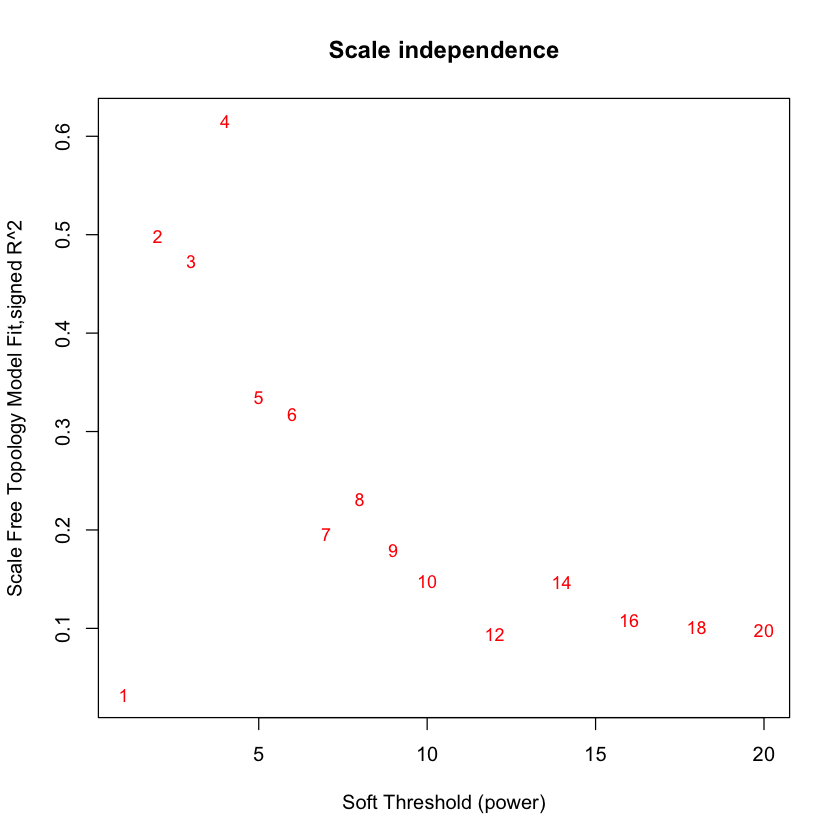

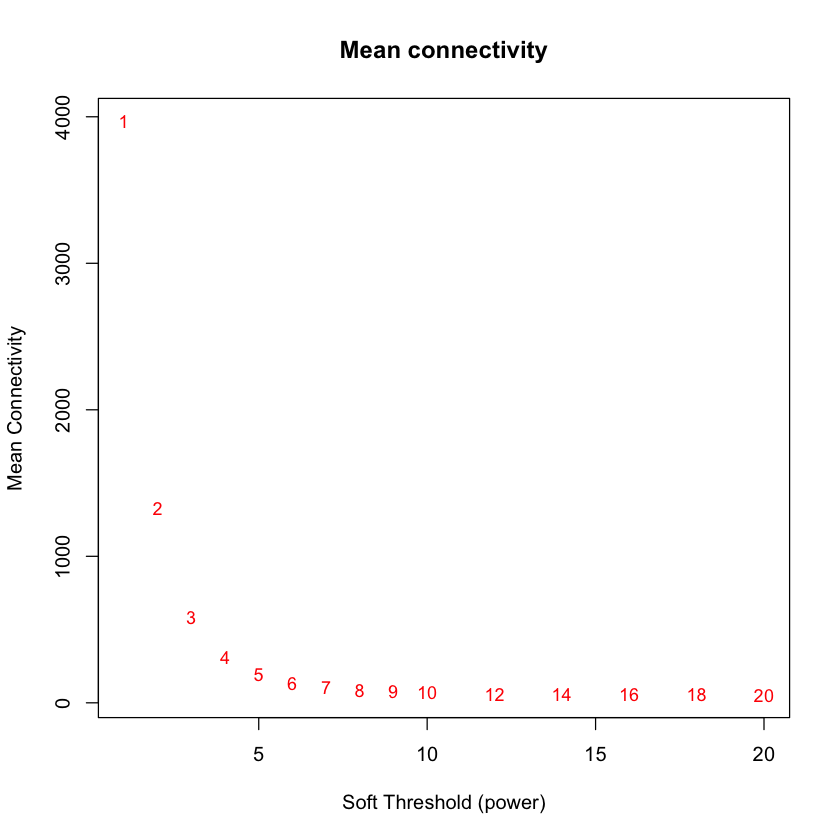

In [92]:
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red");

abline(h=0.90,col="red")

plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

<a id=9 ></a>
## 9. Construct network
After soft thresholding, we construct our network using the `blockwiseModules()` function. The `power` should be selected based on where the soft thresholding line plateaus. The `minModuleSize` indicates the minimum number of transcripts that can be assigned to a given module. That value can be adjusted to increase or reduce complexity in your network. Typically higher values will reduce the number of modules and lower values will increase the number of modules. Finally, `TOMtype` can be "signed" or "unsigned". We chose "signed" due to its power in module detection discussion in a WGCNA seminar.

In [93]:
net <- blockwiseModules(counts_trans, power = 12,
                       TOMType = "signed", minModuleSize = 50,
                       reassignThreshold = 0, mergeCutHeight = 0.25,
                       numericLabels = TRUE, pamRespectsDendro = FALSE,
                       saveTOMs = TRUE,
                       saveTOMFileBase = "LarvalBacteria_net",
                       verbose = 3)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ....pre-clustering genes to determine blocks..
   Projective K-means:
   ..k-means clustering..
   ..merging smaller clusters...
Block sizes:
gBlocks
   1    2    3    4 
4882 4874 4717 3854 
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file LarvalBacteria_net-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 1 genes from module 1 because their KME is too low.
     ..removing 5 genes from module 3 because their KME is too low.
     ..removing 5 genes from module 5 because their KME is too low.
     ..removing 1 genes from module 7 because their K

Once the network is constructed we can look at how many modules were detected using the following command.

In [106]:
table(net$colors)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
3330 1731 1342  969  886  877  876  650  625  569  528  503  470  467  461  438 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
 334  319  255  249  206  190  184  182  176  162  160  148  146  121  111  104 
  32   33   34   35   36   37 
 101   99   97   96   86   79 

Module 0 indicates the transcripts that did not fit into any module, meaning we have a total of 37 biological modules ranging in size from 1731 transcripts to 79 transcripts.

<a id=10 ></a>
## 10. Plot module dendrogram
We can visualize these modules using a dendrogram where each branch is a transcript and the color blocks at the bottom indicate the module that transcript was assigned to. The first block of code below sets the dimensions for the plot window. The second block of code converts the module numbers to colors. And finally, the third block of code plots the dendrogram.

In [107]:
sizeGrWindow(12, 9)

In [108]:
mergedColors = labels2colors(net$colors)

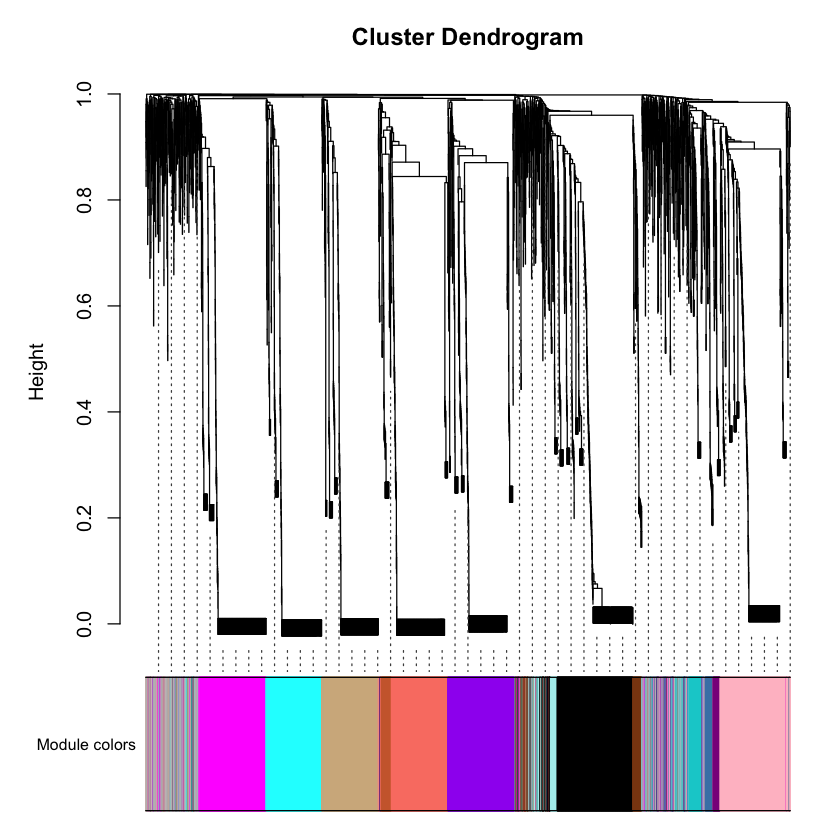

In [109]:
plotDendroAndColors(net$dendrograms[[1]], mergedColors[net$blockGenes[[1]]],
                    "Module colors",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

We can then extract the labels from the network and generate a new dataframe with the eigengene for each sample by module. We then use the second block of code to swap the numbered module label for a color label.

In [120]:
moduleLabels <- net$colors
moduleColors <- labels2colors(net$colors)
MEs <- net$MEs;
geneTree <- net$dendrograms[[1]];

In [121]:
MEs0 <- moduleEigengenes(counts_trans, mergedColors)$eigengenes
MEs0 <- orderMEs(MEs0)
module_order = names(MEs0) %>% gsub("ME","", .)

<a id=11 ></a> 
## Calculate metadata module correlations
In this section, we calculate the correlations between the module eigengenes for each sample and the treatment groups in pairwise comparisons using the binary metadata file we generated above. The binary metadata columns include three comparisons (i.e. pathogen vs control, probiotic vs. pathogen, and probiotic vs. control). We start by adding the treatments to the dataframe `MEs0` generated above and then run the Pearson correlation using `bicor()` and tested for significance using `corPvalueStudent()`.

In [122]:
MEs0$treatment = metadata_filtered$treatment
moduleTraitCor = bicor(MEs, metadata_binary, use = "pairwise.complete.obs");
write.csv(moduleTraitCor,"Module_corr_val.csv")
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples);
write.csv(moduleTraitPvalue,"Module_pval.csv")

Next we set up a text matrix with the correlation and p-values from the previous step and plot a heatmap representing the relationships between each module and the treatment comparisons.

function (n) 
{
    x <- ramp(seq.int(0, 1, length.out = n))
    if (ncol(x) == 4L) 
        rgb(x[, 1L], x[, 2L], x[, 3L], x[, 4L], maxColorValue = 255)
    else rgb(x[, 1L], x[, 2L], x[, 3L], maxColorValue = 255)
}
<bytecode: 0x164d4c780>
<environment: 0x165b158e8>

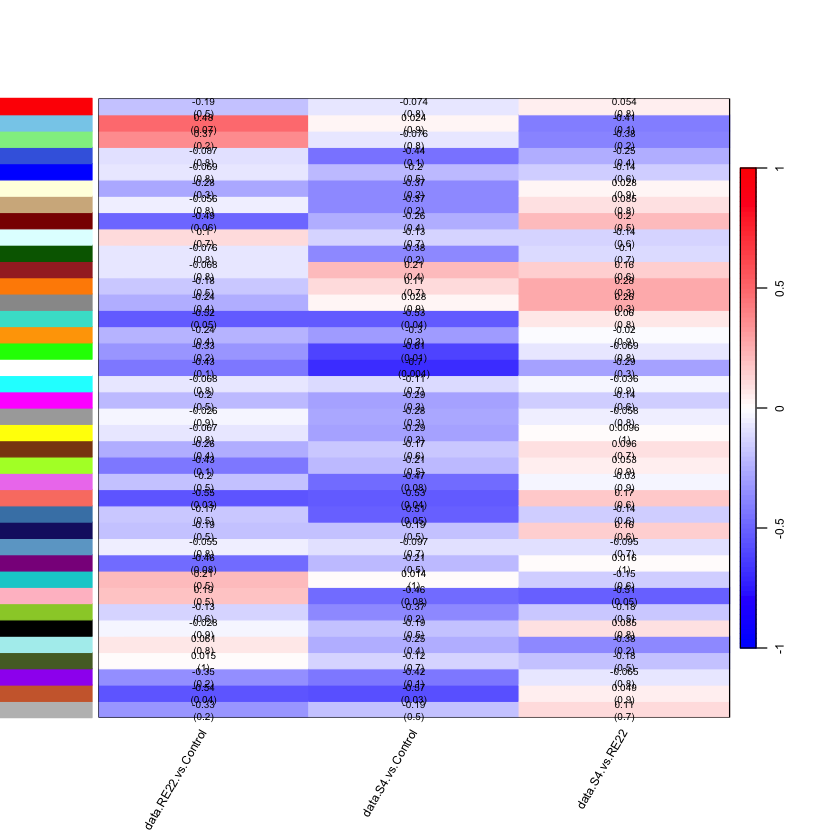

In [123]:
textMatrix =  paste(signif(moduleTraitCor, 2), "\n(",
                    signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)
colors = c("blue","white", "red")
colorRampPalette(colors)
labeledHeatmap(Matrix = moduleTraitCor,
               xLabels = names(metadata_binary),
               yLabels = names(MEs0[1:38]),
               ySymbols = names(MEs0[1:38]),
               xLabelsAngle = 60,
               colorLabels = FALSE,
               colors =  colorRampPalette(colors)(100),
               textMatrix = textMatrix,
               setStdMargins = FALSE,
               yColorWidth = 100,
               cex.text = 0.5,
               cex.lab = 0.6,
               yColorOffset = 0.01,
               zlim = c(-1,1))

Given, the large number of modules, we chose to filter to only the modules that had a correlation p-value of <0.1 in at least one comparison.

In [124]:
moduleTraitPvalue_sig <- subset(as.data.frame(moduleTraitPvalue), data.RE22.vs.Control <= 0.1 | data.S4.vs.Control <= 0.1 | data.S4.vs.RE22 <= 0.1)
moduleTraitCor_sig <- subset(as.data.frame(moduleTraitCor), rownames(moduleTraitCor) %in% rownames(moduleTraitPvalue_sig))

Here, we then construct a new dataframe that includes module number and color columns and then merge in the significant correlation and p-values so they are all contained into two dataframes, one for each.

In [125]:
module_key <- data.frame("moduleNum" = names(MEs), "moduleColor" = names(MEs0[1:38]))
merged_moduleCor_sig <- merge(moduleTraitCor_sig, module_key, by.x = "row.names", by.y = "moduleNum", all.x = TRUE)
merged_modulePvalue_sig <- merge(moduleTraitPvalue_sig, module_key, by.x = "row.names", by.y = "moduleNum", all.x = TRUE)

Once the dataframes are assembled, we used the melt function to convert the dataframes to a long format using the `melt()` function from `reshape2`. Doing this will make plotting the heatmap in ggplot much easier. 

In [239]:
moduleTraitCor_sig_long <- melt(merged_moduleCor_sig, id.vars = c("Row.names","moduleColor"))
moduleTraitPvalue_sig_long <- melt(merged_modulePvalue_sig, id.vars = c("Row.names","moduleColor"))

Next, we plot just the significant modules in a heatmap using `ggplot()`.

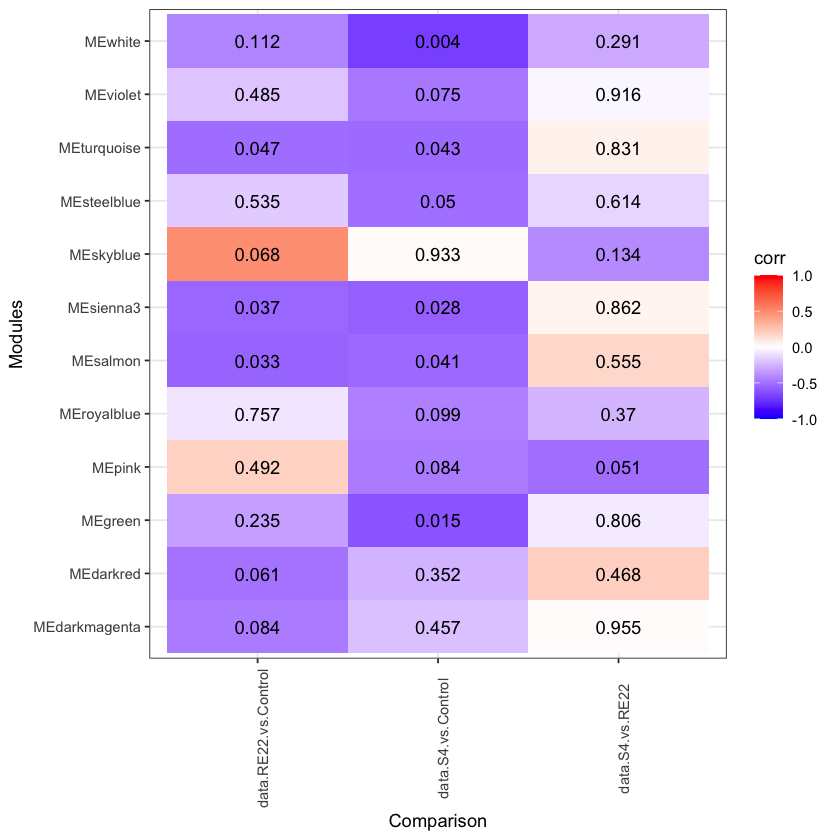

In [240]:
sig_heatmap <- ggplot() + 
  geom_tile(data = moduleTraitCor_sig_long, aes(variable, moduleColor, fill = value)) +
  geom_text(data = moduleTraitPvalue_sig_long, aes(variable, moduleColor, label = round(value, 3))) +
  theme_bw() +
  scale_fill_gradient2(
    low = "blue",
    high = "red",
    mid = "white",
    midpoint = 0,
    limit = c(-1,1)) +
  theme(axis.text.x = element_text(angle=90)) +
  labs(y = "Modules", x = "Comparison", fill="corr")
sig_heatmap

Using the initial heatmap, I designated a specific plotting order for the modules based on their correlations so that modules that correlated similarly across comparisons were grouped together. I also created a new column with cluster as a category to facet by response type (i.e. bacterial response, pathogen response, or probiotic response. I then replotted the heatmap with the new order for a final "clean" heatmap figure.

In [272]:
moduleTraitCor_sig_long$moduleColor <- factor(moduleTraitCor_sig_long$moduleColor, levels = c("MEsalmon",
                                                                                              "MEsienna3",
                                                                                              "MEturquoise",
                                                                                              "MEdarkred",
                                                                                              "MEdarkmagenta",
                                                                                              "MEwhite",
                                                                                              "MEgreen",
                                                                                              "MEviolet",
                                                                                              "MEsteelblue",
                                                                                              "MEroyalblue",
                                                                                              "MEpink",
                                                                                              "MEskyblue"))

In [247]:
moduleTraitCor_sig_long <- moduleTraitCor_sig_long %>% mutate(cluster = case_when(moduleColor == "MEsalmon" ~ "cluster1",
                                                                                  moduleColor == "MEsienna3" ~ "cluster1",
                                                                                  moduleColor == "MEturquoise" ~ "cluster1",
                                                                                  moduleColor == "MEdarkred" ~ "cluster2",
                                                                                  moduleColor == "MEdarkmagenta" ~ "cluster2",
                                                                                  moduleColor == "MEwhite" ~ "cluster3",
                                                                                  moduleColor == "MEgreen" ~ "cluster3",
                                                                                  moduleColor == "MEviolet" ~ "cluster3",
                                                                                  moduleColor == "MEsteelblue" ~ "cluster3",
                                                                                  moduleColor == "MEroyalblue" ~ "cluster3",
                                                                                  moduleColor == "MEpink" ~ "cluster3",
                                                                                  moduleColor == "MEskyblue" ~ "cluster4"))

moduleTraitPvalue_sig_long <- moduleTraitPvalue_sig_long %>% mutate(cluster = case_when(moduleColor == "MEsalmon" ~ "cluster1",
                                                                                        moduleColor == "MEsienna3" ~ "cluster1",
                                                                                        moduleColor == "MEturquoise" ~ "cluster1",
                                                                                        moduleColor == "MEdarkred" ~ "cluster2",
                                                                                        moduleColor == "MEdarkmagenta" ~ "cluster2",
                                                                                        moduleColor == "MEwhite" ~ "cluster3",
                                                                                        moduleColor == "MEgreen" ~ "cluster3",
                                                                                        moduleColor == "MEviolet" ~ "cluster3",
                                                                                        moduleColor == "MEsteelblue" ~ "cluster3",
                                                                                        moduleColor == "MEroyalblue" ~ "cluster3",
                                                                                        moduleColor == "MEpink" ~ "cluster3",
                                                                                        moduleColor == "MEskyblue" ~ "cluster4"))

In [248]:
moduleTraitCor_sig_long$category <- "none"
moduleTraitPvalue_sig_long$category <- "none"

In [261]:
moduleTraitCor_sig_long$cluster <- factor(moduleTraitCor_sig_long$cluster, levels = c("cluster4","cluster2","cluster3","cluster1"))
moduleTraitPvalue_sig_long$cluster <- factor(moduleTraitPvalue_sig_long$cluster, levels = c("cluster4","cluster2","cluster3","cluster1"))

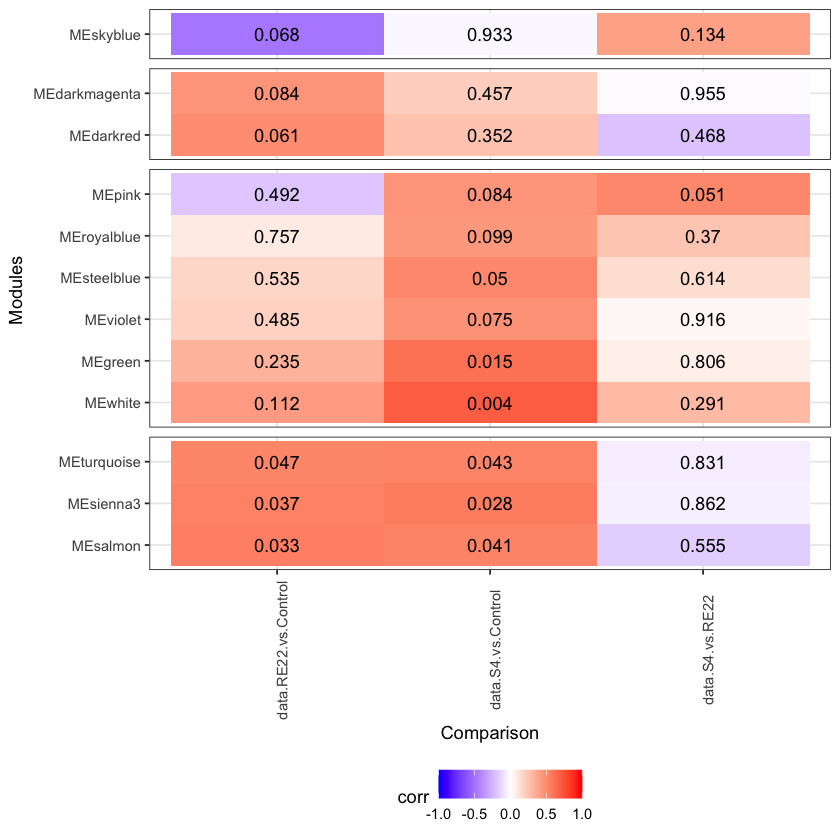

In [264]:
clean_heatmap <- ggplot() + 
  geom_tile(data = moduleTraitCor_sig_long, aes(variable, moduleColor, fill = value*-1)) +
  geom_text(data = moduleTraitPvalue_sig_long, aes(variable, moduleColor, label = round(value, 3))) +
  theme_bw() +
  scale_fill_gradient2(
    low = "blue",
    high = "red",
    mid = "white",
    midpoint = 0,
    limit = c(-1,1)) +
  theme(axis.text.x = element_text(angle=90)) +
  labs(x = "Comparison", y = "Modules", fill="corr") +
  theme(legend.position = "bottom") + 
  facet_grid(cluster~category, space = "free", scale = "free") +
  theme(strip.background = element_blank(), strip.text = element_blank()) 
clean_heatmap

## 12. Calculating functional enrichment in modules
To calculate functional enrichment in our WGCNA modules, we used a hypergeometric test in the STRINGdb package in R. This package allows us to identify biological processes and pathways that occur frquently within each individual module. The package also incorporates multiple databases into its enrichment analysis allowing us to look for enrichment of gene ontology (GO) terms and Kyoto Encyclopedia of Genes and Genomes (KEGG) pathways simultaneously. To start, we must initialize the STRINGdb package using the following command.

#### STRINGdb citation
Szklarczyk, D., Nastou, K., Koutrouli, M., Kirsch, R., Mehryary, F., Hachilif, R., ... & von Mering, C. (2025). The STRING database in 2025: protein networks with directionality of regulation. Nucleic Acids Research, 53(D1), D730-D737.

In [131]:
string_db <- STRINGdb$new(version="12.0", species=50429, score_threshold=400, input_directory="")

After initializing the package, we import two data tables. The first is the correlation output from WGCNA. This dataframe will have two columns for each module, one which includes the module membership value for each transcript in the dataset for the indicated module and one with the p-value telling you the significance of that membership. 

The second dataframe we will import is the annotations for our reference transcriptome. This dataframe inclues the transcript ID and GO annotation when possible for all transcripts in the reference.

In [132]:
data <- read.csv("WGCNA_corrs.csv")
annotations <- read.table("~/Desktop/TXST/AStrangiaTranscriptome/astrangia_annos_clean.txt", sep = "\t", quote = "", fill = TRUE, header = TRUE)

After importing both dataframes, we merge them together to include all data in a single dataframe.

In [133]:
merged_data <- merge(data, annotations, by = "transcript", all.x = TRUE)
head(merged_data)

transcript                moduleColor GS.metadata_binary.data.RE22.vs.Control
1 TRINITY_DN1_c1_g1_i1      turquoise    0.23300369                            
2 TRINITY_DN1000_c0_g1_i1   brown       -0.02832274                            
3 TRINITY_DN1000_c1_g1_i2   turquoise   -0.17276240                            
4 TRINITY_DN10002_c0_g1_i1  blue        -0.15275107                            
5 TRINITY_DN100053_c0_g1_i1 grey        -0.06168642                            
6 TRINITY_DN10006_c0_g1_i6  grey60       0.15950606                            
  p.GS.metadata_binary.data.RE22.vs.Control MM.lightgreen p.MM.lightgreen
1 0.4033095                                  0.206443448  0.4603949      
2 0.9201886                                  0.392967142  0.1473432      
3 0.5380817                                  0.086279989  0.7598015      
4 0.5867958                                 -0.391545155  0.1489442      
5 0.8271247                                 -0.004349337  0.9877263      
6 0.5701526                                  0.302441509  0.2732333      
  MM.skyblue  p.MM.skyblue MM.darkred    p.MM.darkred ⋯ MM.orange   
1 -0.36315998 0.1833659     0.2561141342 0.35685626   ⋯ -0.003688518
2 -0.06819888 0.8091687     0.0410966362 0.88438062   ⋯ -0.112028217
3 -0.42059978 0.1184992    -0.0007299294 0.99794009   ⋯  0.058066242
4  0.22724285 0.4153622     0.5465124668 0.03503301   ⋯  0.534380858
5  0.06576482 0.8158700    -0.3599422023 0.18756837   ⋯  0.129891717
6  0.13097438 0.6417398    -0.1189626421 0.67282485   ⋯ -0.036216594
  p.MM.orange MM.brown   p.MM.brown MM.lightyellow p.MM.lightyellow spID  
1 0.98959100   0.1154613 0.68198192  0.2881045     0.29773091       Q9JI12
2 0.69100064   0.5110585 0.05154145  0.2946143     0.28645270       Q8VHQ7
3 0.83714122  -0.2466889 0.37543019  0.2048033     0.46404463       Q9V895
4 0.04015576   0.2177323 0.43566239 -0.5654412     0.02803861       Q8R512
5 0.64452002  -0.2809378 0.31044381 -0.1247746     0.65771915       Q805A1
6 0.89803950   0.1675441 0.55061077  0.1570276     0.57623602       NA    
  X      
1 Slc17a6
2 Sytl4  
3 Anp32a 
4 Ubxn11 
5 smc5   
6 NA     
  X.1                                                                                                                                                                                                                                                                                                                                                       
1 GO:0001504; GO:0003407; GO:0005254; GO:0005313; GO:0005326; GO:0005436; GO:0005769; GO:0005886; GO:0006817; GO:0006820; GO:0008021; GO:0015386; GO:0015813; GO:0021766; GO:0030672; GO:0034707; GO:0035249; GO:0043005; GO:0044341; GO:0050803; GO:0051938; GO:0055062; GO:0060076; GO:0098700; GO:0098793; GO:0140787; GO:0140788; GO:1990030; GO:1990384
2 GO:0001778; GO:0005543; GO:0005768; GO:0005886; GO:0006886; GO:0006887; GO:0016324; GO:0030073; GO:0030141; GO:0030658; GO:0031267; GO:0032418; GO:0042043; GO:0045921; GO:0046676; GO:0046872; GO:0050714; GO:0070382; GO:0071985; GO:1905684                                                                                                            
3 GO:0005634; GO:0005654; GO:0005737; GO:0005783; GO:0006913; GO:0042393; GO:0048471                                                                                                                                                                                                                                                                        
4 GO:0005737; GO:0005856; GO:0043130; GO:0043161                                                                                                                                                                                                                                                                                                            
5 GO:0000722; GO:0000724; GO:0000781; GO:0005524; GO:0005634; GO:0007049; GO:0016605; GO:0016887; GO:

Next we will create a separate dataframe for each module by filtering to only the module membership and p-value columns that belong to each of the modules.

*Module: skyblue*

In [134]:
skyblue_data <- subset(merged_data, moduleColor == "skyblue")
names(skyblue_data)

[1] "transcript"                               
 [2] "moduleColor"                              
 [3] "GS.metadata_binary.data.RE22.vs.Control"  
 [4] "p.GS.metadata_binary.data.RE22.vs.Control"
 [5] "MM.lightgreen"                            
 [6] "p.MM.lightgreen"                          
 [7] "MM.skyblue"                               
 [8] "p.MM.skyblue"                             
 [9] "MM.darkred"                               
[10] "p.MM.darkred"                             
[11] "MM.turquoise"                             
[12] "p.MM.turquoise"                           
[13] "MM.royalblue"                             
[14] "p.MM.royalblue"                           
[15] "MM.darkturquoise"                         
[16] "p.MM.darkturquoise"                       
[17] "MM.white"                                 
[18] "p.MM.white"                               
[19] "MM.darkmagenta"                           
[20] "p.MM.darkmagenta"                         
[21] "MM.green"                                 
[22] "p.MM.green"                               
[23] "MM.saddlebrown"                           
[24] "p.MM.saddlebrown"                         
[25] "MM.midnightblue"                          
[26] "p.MM.midnightblue"                        
[27] "MM.darkorange"                            
[28] "p.MM.darkorange"                          
[29] "MM.steelblue"                             
[30] "p.MM.steelblue"                           
[31] "MM.grey"                                  
[32] "p.MM.grey"                                
[33] "MM.yellowgreen"                           
[34] "p.MM.yellowgreen"                         
[35] "MM.tan"                                   
[36] "p.MM.tan"                                 
[37] "MM.black"                                 
[38] "p.MM.black"                               
[39] "MM.skyblue3"                              
[40] "p.MM.skyblue3"                            
[41] "MM.magenta"                               
[42] "p.MM.magenta"                             
[43] "MM.blue"                                  
[44] "p.MM.blue"                                
[45] "MM.salmon"                                
[46] "p.MM.salmon"                              
[47] "MM.cyan"                                  
[48] "p.MM.cyan"                                
[49] "MM.violet"                                
[50] "p.MM.violet"                              
[51] "MM.darkgrey"                              
[52] "p.MM.darkgrey"                            
[53] "MM.pink"                                  
[54] "p.MM.pink"                                
[55] "MM.red"                                   
[56] "p.MM.red"                                 
[57] "MM.paleturquoise"                         
[58] "p.MM.paleturquoise"                       
[59] "MM.yellow"                                
[60] "p.MM.yellow"                              
[61] "MM.lightcyan"                             
[62] "p.MM.lightcyan"                           
[63] "MM.darkgreen"                             
[64] "p.MM.darkgreen"                           
[65] "MM.greenyellow"                           
[66] "p.MM.greenyellow"                         
[67] "MM.sienna3"                               
[68] "p.MM.sienna3"                             
[69] "MM.grey60"                                
[70] "p.MM.grey60"                              
[71] "MM.purple"                                
[72] "p.MM.purple"                              
[73] "MM.darkolivegreen"                        
[74] "p.MM.darkolivegreen"                      
[75] "MM.orange"                                
[76] "p.MM.orange"                              
[77] "MM.brown"                                 
[78] "p.MM.brown"                               
[79] "MM.lightyellow"                           
[80] "p.MM.lightyellow"                         
[81] "spID"                                     
[82] "X"                        

In [135]:
skyblue_proteins <- skyblue_data[,c(1,2,7,8,82)]

*Module: pink*

In [136]:
pink_data <- subset(merged_data, moduleColor == "pink")
names(pink_data)

[1] "transcript"                               
 [2] "moduleColor"                              
 [3] "GS.metadata_binary.data.RE22.vs.Control"  
 [4] "p.GS.metadata_binary.data.RE22.vs.Control"
 [5] "MM.lightgreen"                            
 [6] "p.MM.lightgreen"                          
 [7] "MM.skyblue"                               
 [8] "p.MM.skyblue"                             
 [9] "MM.darkred"                               
[10] "p.MM.darkred"                             
[11] "MM.turquoise"                             
[12] "p.MM.turquoise"                           
[13] "MM.royalblue"                             
[14] "p.MM.royalblue"                           
[15] "MM.darkturquoise"                         
[16] "p.MM.darkturquoise"                       
[17] "MM.white"                                 
[18] "p.MM.white"                               
[19] "MM.darkmagenta"                           
[20] "p.MM.darkmagenta"                         
[21] "MM.green"                                 
[22] "p.MM.green"                               
[23] "MM.saddlebrown"                           
[24] "p.MM.saddlebrown"                         
[25] "MM.midnightblue"                          
[26] "p.MM.midnightblue"                        
[27] "MM.darkorange"                            
[28] "p.MM.darkorange"                          
[29] "MM.steelblue"                             
[30] "p.MM.steelblue"                           
[31] "MM.grey"                                  
[32] "p.MM.grey"                                
[33] "MM.yellowgreen"                           
[34] "p.MM.yellowgreen"                         
[35] "MM.tan"                                   
[36] "p.MM.tan"                                 
[37] "MM.black"                                 
[38] "p.MM.black"                               
[39] "MM.skyblue3"                              
[40] "p.MM.skyblue3"                            
[41] "MM.magenta"                               
[42] "p.MM.magenta"                             
[43] "MM.blue"                                  
[44] "p.MM.blue"                                
[45] "MM.salmon"                                
[46] "p.MM.salmon"                              
[47] "MM.cyan"                                  
[48] "p.MM.cyan"                                
[49] "MM.violet"                                
[50] "p.MM.violet"                              
[51] "MM.darkgrey"                              
[52] "p.MM.darkgrey"                            
[53] "MM.pink"                                  
[54] "p.MM.pink"                                
[55] "MM.red"                                   
[56] "p.MM.red"                                 
[57] "MM.paleturquoise"                         
[58] "p.MM.paleturquoise"                       
[59] "MM.yellow"                                
[60] "p.MM.yellow"                              
[61] "MM.lightcyan"                             
[62] "p.MM.lightcyan"                           
[63] "MM.darkgreen"                             
[64] "p.MM.darkgreen"                           
[65] "MM.greenyellow"                           
[66] "p.MM.greenyellow"                         
[67] "MM.sienna3"                               
[68] "p.MM.sienna3"                             
[69] "MM.grey60"                                
[70] "p.MM.grey60"                              
[71] "MM.purple"                                
[72] "p.MM.purple"                              
[73] "MM.darkolivegreen"                        
[74] "p.MM.darkolivegreen"                      
[75] "MM.orange"                                
[76] "p.MM.orange"                              
[77] "MM.brown"                                 
[78] "p.MM.brown"                               
[79] "MM.lightyellow"                           
[80] "p.MM.lightyellow"                         
[81] "spID"                                     
[82] "X"                        

In [137]:
pink_proteins <- pink_data[,c(1,2,53,54,82)]

*Module: royalblue*

In [138]:
royalblue_data <- subset(merged_data, moduleColor == "royalblue")
names(royalblue_data)

[1] "transcript"                               
 [2] "moduleColor"                              
 [3] "GS.metadata_binary.data.RE22.vs.Control"  
 [4] "p.GS.metadata_binary.data.RE22.vs.Control"
 [5] "MM.lightgreen"                            
 [6] "p.MM.lightgreen"                          
 [7] "MM.skyblue"                               
 [8] "p.MM.skyblue"                             
 [9] "MM.darkred"                               
[10] "p.MM.darkred"                             
[11] "MM.turquoise"                             
[12] "p.MM.turquoise"                           
[13] "MM.royalblue"                             
[14] "p.MM.royalblue"                           
[15] "MM.darkturquoise"                         
[16] "p.MM.darkturquoise"                       
[17] "MM.white"                                 
[18] "p.MM.white"                               
[19] "MM.darkmagenta"                           
[20] "p.MM.darkmagenta"                         
[21] "MM.green"                                 
[22] "p.MM.green"                               
[23] "MM.saddlebrown"                           
[24] "p.MM.saddlebrown"                         
[25] "MM.midnightblue"                          
[26] "p.MM.midnightblue"                        
[27] "MM.darkorange"                            
[28] "p.MM.darkorange"                          
[29] "MM.steelblue"                             
[30] "p.MM.steelblue"                           
[31] "MM.grey"                                  
[32] "p.MM.grey"                                
[33] "MM.yellowgreen"                           
[34] "p.MM.yellowgreen"                         
[35] "MM.tan"                                   
[36] "p.MM.tan"                                 
[37] "MM.black"                                 
[38] "p.MM.black"                               
[39] "MM.skyblue3"                              
[40] "p.MM.skyblue3"                            
[41] "MM.magenta"                               
[42] "p.MM.magenta"                             
[43] "MM.blue"                                  
[44] "p.MM.blue"                                
[45] "MM.salmon"                                
[46] "p.MM.salmon"                              
[47] "MM.cyan"                                  
[48] "p.MM.cyan"                                
[49] "MM.violet"                                
[50] "p.MM.violet"                              
[51] "MM.darkgrey"                              
[52] "p.MM.darkgrey"                            
[53] "MM.pink"                                  
[54] "p.MM.pink"                                
[55] "MM.red"                                   
[56] "p.MM.red"                                 
[57] "MM.paleturquoise"                         
[58] "p.MM.paleturquoise"                       
[59] "MM.yellow"                                
[60] "p.MM.yellow"                              
[61] "MM.lightcyan"                             
[62] "p.MM.lightcyan"                           
[63] "MM.darkgreen"                             
[64] "p.MM.darkgreen"                           
[65] "MM.greenyellow"                           
[66] "p.MM.greenyellow"                         
[67] "MM.sienna3"                               
[68] "p.MM.sienna3"                             
[69] "MM.grey60"                                
[70] "p.MM.grey60"                              
[71] "MM.purple"                                
[72] "p.MM.purple"                              
[73] "MM.darkolivegreen"                        
[74] "p.MM.darkolivegreen"                      
[75] "MM.orange"                                
[76] "p.MM.orange"                              
[77] "MM.brown"                                 
[78] "p.MM.brown"                               
[79] "MM.lightyellow"                           
[80] "p.MM.lightyellow"                         
[81] "spID"                                     
[82] "X"                        

In [139]:
royalblue_proteins <- royalblue_data[,c(1,2,13,14,82)]

*Module: steelblue*

In [140]:
steelblue_data <- subset(merged_data, moduleColor == "steelblue")
names(steelblue_data)

[1] "transcript"                               
 [2] "moduleColor"                              
 [3] "GS.metadata_binary.data.RE22.vs.Control"  
 [4] "p.GS.metadata_binary.data.RE22.vs.Control"
 [5] "MM.lightgreen"                            
 [6] "p.MM.lightgreen"                          
 [7] "MM.skyblue"                               
 [8] "p.MM.skyblue"                             
 [9] "MM.darkred"                               
[10] "p.MM.darkred"                             
[11] "MM.turquoise"                             
[12] "p.MM.turquoise"                           
[13] "MM.royalblue"                             
[14] "p.MM.royalblue"                           
[15] "MM.darkturquoise"                         
[16] "p.MM.darkturquoise"                       
[17] "MM.white"                                 
[18] "p.MM.white"                               
[19] "MM.darkmagenta"                           
[20] "p.MM.darkmagenta"                         
[21] "MM.green"                                 
[22] "p.MM.green"                               
[23] "MM.saddlebrown"                           
[24] "p.MM.saddlebrown"                         
[25] "MM.midnightblue"                          
[26] "p.MM.midnightblue"                        
[27] "MM.darkorange"                            
[28] "p.MM.darkorange"                          
[29] "MM.steelblue"                             
[30] "p.MM.steelblue"                           
[31] "MM.grey"                                  
[32] "p.MM.grey"                                
[33] "MM.yellowgreen"                           
[34] "p.MM.yellowgreen"                         
[35] "MM.tan"                                   
[36] "p.MM.tan"                                 
[37] "MM.black"                                 
[38] "p.MM.black"                               
[39] "MM.skyblue3"                              
[40] "p.MM.skyblue3"                            
[41] "MM.magenta"                               
[42] "p.MM.magenta"                             
[43] "MM.blue"                                  
[44] "p.MM.blue"                                
[45] "MM.salmon"                                
[46] "p.MM.salmon"                              
[47] "MM.cyan"                                  
[48] "p.MM.cyan"                                
[49] "MM.violet"                                
[50] "p.MM.violet"                              
[51] "MM.darkgrey"                              
[52] "p.MM.darkgrey"                            
[53] "MM.pink"                                  
[54] "p.MM.pink"                                
[55] "MM.red"                                   
[56] "p.MM.red"                                 
[57] "MM.paleturquoise"                         
[58] "p.MM.paleturquoise"                       
[59] "MM.yellow"                                
[60] "p.MM.yellow"                              
[61] "MM.lightcyan"                             
[62] "p.MM.lightcyan"                           
[63] "MM.darkgreen"                             
[64] "p.MM.darkgreen"                           
[65] "MM.greenyellow"                           
[66] "p.MM.greenyellow"                         
[67] "MM.sienna3"                               
[68] "p.MM.sienna3"                             
[69] "MM.grey60"                                
[70] "p.MM.grey60"                              
[71] "MM.purple"                                
[72] "p.MM.purple"                              
[73] "MM.darkolivegreen"                        
[74] "p.MM.darkolivegreen"                      
[75] "MM.orange"                                
[76] "p.MM.orange"                              
[77] "MM.brown"                                 
[78] "p.MM.brown"                               
[79] "MM.lightyellow"                           
[80] "p.MM.lightyellow"                         
[81] "spID"                                     
[82] "X"                        

In [141]:
steelblue_proteins <- steelblue_data[,c(1,2,29,30,82)]

*Module: violet*

In [142]:
violet_data <- subset(merged_data, moduleColor == "violet")
names(violet_data)

[1] "transcript"                               
 [2] "moduleColor"                              
 [3] "GS.metadata_binary.data.RE22.vs.Control"  
 [4] "p.GS.metadata_binary.data.RE22.vs.Control"
 [5] "MM.lightgreen"                            
 [6] "p.MM.lightgreen"                          
 [7] "MM.skyblue"                               
 [8] "p.MM.skyblue"                             
 [9] "MM.darkred"                               
[10] "p.MM.darkred"                             
[11] "MM.turquoise"                             
[12] "p.MM.turquoise"                           
[13] "MM.royalblue"                             
[14] "p.MM.royalblue"                           
[15] "MM.darkturquoise"                         
[16] "p.MM.darkturquoise"                       
[17] "MM.white"                                 
[18] "p.MM.white"                               
[19] "MM.darkmagenta"                           
[20] "p.MM.darkmagenta"                         
[21] "MM.green"                                 
[22] "p.MM.green"                               
[23] "MM.saddlebrown"                           
[24] "p.MM.saddlebrown"                         
[25] "MM.midnightblue"                          
[26] "p.MM.midnightblue"                        
[27] "MM.darkorange"                            
[28] "p.MM.darkorange"                          
[29] "MM.steelblue"                             
[30] "p.MM.steelblue"                           
[31] "MM.grey"                                  
[32] "p.MM.grey"                                
[33] "MM.yellowgreen"                           
[34] "p.MM.yellowgreen"                         
[35] "MM.tan"                                   
[36] "p.MM.tan"                                 
[37] "MM.black"                                 
[38] "p.MM.black"                               
[39] "MM.skyblue3"                              
[40] "p.MM.skyblue3"                            
[41] "MM.magenta"                               
[42] "p.MM.magenta"                             
[43] "MM.blue"                                  
[44] "p.MM.blue"                                
[45] "MM.salmon"                                
[46] "p.MM.salmon"                              
[47] "MM.cyan"                                  
[48] "p.MM.cyan"                                
[49] "MM.violet"                                
[50] "p.MM.violet"                              
[51] "MM.darkgrey"                              
[52] "p.MM.darkgrey"                            
[53] "MM.pink"                                  
[54] "p.MM.pink"                                
[55] "MM.red"                                   
[56] "p.MM.red"                                 
[57] "MM.paleturquoise"                         
[58] "p.MM.paleturquoise"                       
[59] "MM.yellow"                                
[60] "p.MM.yellow"                              
[61] "MM.lightcyan"                             
[62] "p.MM.lightcyan"                           
[63] "MM.darkgreen"                             
[64] "p.MM.darkgreen"                           
[65] "MM.greenyellow"                           
[66] "p.MM.greenyellow"                         
[67] "MM.sienna3"                               
[68] "p.MM.sienna3"                             
[69] "MM.grey60"                                
[70] "p.MM.grey60"                              
[71] "MM.purple"                                
[72] "p.MM.purple"                              
[73] "MM.darkolivegreen"                        
[74] "p.MM.darkolivegreen"                      
[75] "MM.orange"                                
[76] "p.MM.orange"                              
[77] "MM.brown"                                 
[78] "p.MM.brown"                               
[79] "MM.lightyellow"                           
[80] "p.MM.lightyellow"                         
[81] "spID"                                     
[82] "X"                        

In [143]:
violet_proteins <- violet_data[,c(1,2,49,50,82)]

*Module: green*

In [144]:
green_data <- subset(merged_data, moduleColor == "green")
names(green_data)

[1] "transcript"                               
 [2] "moduleColor"                              
 [3] "GS.metadata_binary.data.RE22.vs.Control"  
 [4] "p.GS.metadata_binary.data.RE22.vs.Control"
 [5] "MM.lightgreen"                            
 [6] "p.MM.lightgreen"                          
 [7] "MM.skyblue"                               
 [8] "p.MM.skyblue"                             
 [9] "MM.darkred"                               
[10] "p.MM.darkred"                             
[11] "MM.turquoise"                             
[12] "p.MM.turquoise"                           
[13] "MM.royalblue"                             
[14] "p.MM.royalblue"                           
[15] "MM.darkturquoise"                         
[16] "p.MM.darkturquoise"                       
[17] "MM.white"                                 
[18] "p.MM.white"                               
[19] "MM.darkmagenta"                           
[20] "p.MM.darkmagenta"                         
[21] "MM.green"                                 
[22] "p.MM.green"                               
[23] "MM.saddlebrown"                           
[24] "p.MM.saddlebrown"                         
[25] "MM.midnightblue"                          
[26] "p.MM.midnightblue"                        
[27] "MM.darkorange"                            
[28] "p.MM.darkorange"                          
[29] "MM.steelblue"                             
[30] "p.MM.steelblue"                           
[31] "MM.grey"                                  
[32] "p.MM.grey"                                
[33] "MM.yellowgreen"                           
[34] "p.MM.yellowgreen"                         
[35] "MM.tan"                                   
[36] "p.MM.tan"                                 
[37] "MM.black"                                 
[38] "p.MM.black"                               
[39] "MM.skyblue3"                              
[40] "p.MM.skyblue3"                            
[41] "MM.magenta"                               
[42] "p.MM.magenta"                             
[43] "MM.blue"                                  
[44] "p.MM.blue"                                
[45] "MM.salmon"                                
[46] "p.MM.salmon"                              
[47] "MM.cyan"                                  
[48] "p.MM.cyan"                                
[49] "MM.violet"                                
[50] "p.MM.violet"                              
[51] "MM.darkgrey"                              
[52] "p.MM.darkgrey"                            
[53] "MM.pink"                                  
[54] "p.MM.pink"                                
[55] "MM.red"                                   
[56] "p.MM.red"                                 
[57] "MM.paleturquoise"                         
[58] "p.MM.paleturquoise"                       
[59] "MM.yellow"                                
[60] "p.MM.yellow"                              
[61] "MM.lightcyan"                             
[62] "p.MM.lightcyan"                           
[63] "MM.darkgreen"                             
[64] "p.MM.darkgreen"                           
[65] "MM.greenyellow"                           
[66] "p.MM.greenyellow"                         
[67] "MM.sienna3"                               
[68] "p.MM.sienna3"                             
[69] "MM.grey60"                                
[70] "p.MM.grey60"                              
[71] "MM.purple"                                
[72] "p.MM.purple"                              
[73] "MM.darkolivegreen"                        
[74] "p.MM.darkolivegreen"                      
[75] "MM.orange"                                
[76] "p.MM.orange"                              
[77] "MM.brown"                                 
[78] "p.MM.brown"                               
[79] "MM.lightyellow"                           
[80] "p.MM.lightyellow"                         
[81] "spID"                                     
[82] "X"                        

In [163]:
green_proteins <- green_data[,c(1,2,21,22,82)]

*Module: white*

In [145]:
white_data <- subset(merged_data, moduleColor == "white")
names(white_data)

[1] "transcript"                               
 [2] "moduleColor"                              
 [3] "GS.metadata_binary.data.RE22.vs.Control"  
 [4] "p.GS.metadata_binary.data.RE22.vs.Control"
 [5] "MM.lightgreen"                            
 [6] "p.MM.lightgreen"                          
 [7] "MM.skyblue"                               
 [8] "p.MM.skyblue"                             
 [9] "MM.darkred"                               
[10] "p.MM.darkred"                             
[11] "MM.turquoise"                             
[12] "p.MM.turquoise"                           
[13] "MM.royalblue"                             
[14] "p.MM.royalblue"                           
[15] "MM.darkturquoise"                         
[16] "p.MM.darkturquoise"                       
[17] "MM.white"                                 
[18] "p.MM.white"                               
[19] "MM.darkmagenta"                           
[20] "p.MM.darkmagenta"                         
[21] "MM.green"                                 
[22] "p.MM.green"                               
[23] "MM.saddlebrown"                           
[24] "p.MM.saddlebrown"                         
[25] "MM.midnightblue"                          
[26] "p.MM.midnightblue"                        
[27] "MM.darkorange"                            
[28] "p.MM.darkorange"                          
[29] "MM.steelblue"                             
[30] "p.MM.steelblue"                           
[31] "MM.grey"                                  
[32] "p.MM.grey"                                
[33] "MM.yellowgreen"                           
[34] "p.MM.yellowgreen"                         
[35] "MM.tan"                                   
[36] "p.MM.tan"                                 
[37] "MM.black"                                 
[38] "p.MM.black"                               
[39] "MM.skyblue3"                              
[40] "p.MM.skyblue3"                            
[41] "MM.magenta"                               
[42] "p.MM.magenta"                             
[43] "MM.blue"                                  
[44] "p.MM.blue"                                
[45] "MM.salmon"                                
[46] "p.MM.salmon"                              
[47] "MM.cyan"                                  
[48] "p.MM.cyan"                                
[49] "MM.violet"                                
[50] "p.MM.violet"                              
[51] "MM.darkgrey"                              
[52] "p.MM.darkgrey"                            
[53] "MM.pink"                                  
[54] "p.MM.pink"                                
[55] "MM.red"                                   
[56] "p.MM.red"                                 
[57] "MM.paleturquoise"                         
[58] "p.MM.paleturquoise"                       
[59] "MM.yellow"                                
[60] "p.MM.yellow"                              
[61] "MM.lightcyan"                             
[62] "p.MM.lightcyan"                           
[63] "MM.darkgreen"                             
[64] "p.MM.darkgreen"                           
[65] "MM.greenyellow"                           
[66] "p.MM.greenyellow"                         
[67] "MM.sienna3"                               
[68] "p.MM.sienna3"                             
[69] "MM.grey60"                                
[70] "p.MM.grey60"                              
[71] "MM.purple"                                
[72] "p.MM.purple"                              
[73] "MM.darkolivegreen"                        
[74] "p.MM.darkolivegreen"                      
[75] "MM.orange"                                
[76] "p.MM.orange"                              
[77] "MM.brown"                                 
[78] "p.MM.brown"                               
[79] "MM.lightyellow"                           
[80] "p.MM.lightyellow"                         
[81] "spID"                                     
[82] "X"                        

In [146]:
white_proteins <- white_data[,c(1,2,17,18,82)]

*Module: darkmagenta*

In [147]:
darkmagenta_data <- subset(merged_data, moduleColor == "darkmagenta")
names(darkmagenta_data)

[1] "transcript"                               
 [2] "moduleColor"                              
 [3] "GS.metadata_binary.data.RE22.vs.Control"  
 [4] "p.GS.metadata_binary.data.RE22.vs.Control"
 [5] "MM.lightgreen"                            
 [6] "p.MM.lightgreen"                          
 [7] "MM.skyblue"                               
 [8] "p.MM.skyblue"                             
 [9] "MM.darkred"                               
[10] "p.MM.darkred"                             
[11] "MM.turquoise"                             
[12] "p.MM.turquoise"                           
[13] "MM.royalblue"                             
[14] "p.MM.royalblue"                           
[15] "MM.darkturquoise"                         
[16] "p.MM.darkturquoise"                       
[17] "MM.white"                                 
[18] "p.MM.white"                               
[19] "MM.darkmagenta"                           
[20] "p.MM.darkmagenta"                         
[21] "MM.green"                                 
[22] "p.MM.green"                               
[23] "MM.saddlebrown"                           
[24] "p.MM.saddlebrown"                         
[25] "MM.midnightblue"                          
[26] "p.MM.midnightblue"                        
[27] "MM.darkorange"                            
[28] "p.MM.darkorange"                          
[29] "MM.steelblue"                             
[30] "p.MM.steelblue"                           
[31] "MM.grey"                                  
[32] "p.MM.grey"                                
[33] "MM.yellowgreen"                           
[34] "p.MM.yellowgreen"                         
[35] "MM.tan"                                   
[36] "p.MM.tan"                                 
[37] "MM.black"                                 
[38] "p.MM.black"                               
[39] "MM.skyblue3"                              
[40] "p.MM.skyblue3"                            
[41] "MM.magenta"                               
[42] "p.MM.magenta"                             
[43] "MM.blue"                                  
[44] "p.MM.blue"                                
[45] "MM.salmon"                                
[46] "p.MM.salmon"                              
[47] "MM.cyan"                                  
[48] "p.MM.cyan"                                
[49] "MM.violet"                                
[50] "p.MM.violet"                              
[51] "MM.darkgrey"                              
[52] "p.MM.darkgrey"                            
[53] "MM.pink"                                  
[54] "p.MM.pink"                                
[55] "MM.red"                                   
[56] "p.MM.red"                                 
[57] "MM.paleturquoise"                         
[58] "p.MM.paleturquoise"                       
[59] "MM.yellow"                                
[60] "p.MM.yellow"                              
[61] "MM.lightcyan"                             
[62] "p.MM.lightcyan"                           
[63] "MM.darkgreen"                             
[64] "p.MM.darkgreen"                           
[65] "MM.greenyellow"                           
[66] "p.MM.greenyellow"                         
[67] "MM.sienna3"                               
[68] "p.MM.sienna3"                             
[69] "MM.grey60"                                
[70] "p.MM.grey60"                              
[71] "MM.purple"                                
[72] "p.MM.purple"                              
[73] "MM.darkolivegreen"                        
[74] "p.MM.darkolivegreen"                      
[75] "MM.orange"                                
[76] "p.MM.orange"                              
[77] "MM.brown"                                 
[78] "p.MM.brown"                               
[79] "MM.lightyellow"                           
[80] "p.MM.lightyellow"                         
[81] "spID"                                     
[82] "X"                        

In [148]:
darkmagenta_proteins <- darkmagenta_data[,c(1,2,19,20,82)]

*Module: darkred*

In [149]:
darkred_data <- subset(merged_data, moduleColor == "darkred")
names(darkred_data)

[1] "transcript"                               
 [2] "moduleColor"                              
 [3] "GS.metadata_binary.data.RE22.vs.Control"  
 [4] "p.GS.metadata_binary.data.RE22.vs.Control"
 [5] "MM.lightgreen"                            
 [6] "p.MM.lightgreen"                          
 [7] "MM.skyblue"                               
 [8] "p.MM.skyblue"                             
 [9] "MM.darkred"                               
[10] "p.MM.darkred"                             
[11] "MM.turquoise"                             
[12] "p.MM.turquoise"                           
[13] "MM.royalblue"                             
[14] "p.MM.royalblue"                           
[15] "MM.darkturquoise"                         
[16] "p.MM.darkturquoise"                       
[17] "MM.white"                                 
[18] "p.MM.white"                               
[19] "MM.darkmagenta"                           
[20] "p.MM.darkmagenta"                         
[21] "MM.green"                                 
[22] "p.MM.green"                               
[23] "MM.saddlebrown"                           
[24] "p.MM.saddlebrown"                         
[25] "MM.midnightblue"                          
[26] "p.MM.midnightblue"                        
[27] "MM.darkorange"                            
[28] "p.MM.darkorange"                          
[29] "MM.steelblue"                             
[30] "p.MM.steelblue"                           
[31] "MM.grey"                                  
[32] "p.MM.grey"                                
[33] "MM.yellowgreen"                           
[34] "p.MM.yellowgreen"                         
[35] "MM.tan"                                   
[36] "p.MM.tan"                                 
[37] "MM.black"                                 
[38] "p.MM.black"                               
[39] "MM.skyblue3"                              
[40] "p.MM.skyblue3"                            
[41] "MM.magenta"                               
[42] "p.MM.magenta"                             
[43] "MM.blue"                                  
[44] "p.MM.blue"                                
[45] "MM.salmon"                                
[46] "p.MM.salmon"                              
[47] "MM.cyan"                                  
[48] "p.MM.cyan"                                
[49] "MM.violet"                                
[50] "p.MM.violet"                              
[51] "MM.darkgrey"                              
[52] "p.MM.darkgrey"                            
[53] "MM.pink"                                  
[54] "p.MM.pink"                                
[55] "MM.red"                                   
[56] "p.MM.red"                                 
[57] "MM.paleturquoise"                         
[58] "p.MM.paleturquoise"                       
[59] "MM.yellow"                                
[60] "p.MM.yellow"                              
[61] "MM.lightcyan"                             
[62] "p.MM.lightcyan"                           
[63] "MM.darkgreen"                             
[64] "p.MM.darkgreen"                           
[65] "MM.greenyellow"                           
[66] "p.MM.greenyellow"                         
[67] "MM.sienna3"                               
[68] "p.MM.sienna3"                             
[69] "MM.grey60"                                
[70] "p.MM.grey60"                              
[71] "MM.purple"                                
[72] "p.MM.purple"                              
[73] "MM.darkolivegreen"                        
[74] "p.MM.darkolivegreen"                      
[75] "MM.orange"                                
[76] "p.MM.orange"                              
[77] "MM.brown"                                 
[78] "p.MM.brown"                               
[79] "MM.lightyellow"                           
[80] "p.MM.lightyellow"                         
[81] "spID"                                     
[82] "X"                        

In [150]:
darkred_proteins <- darkred_data[,c(1,2,9,10,82)]

*Module: turquoise*

In [151]:
turquoise_data <- subset(merged_data, moduleColor == "turquoise")
names(turquoise_data)

[1] "transcript"                               
 [2] "moduleColor"                              
 [3] "GS.metadata_binary.data.RE22.vs.Control"  
 [4] "p.GS.metadata_binary.data.RE22.vs.Control"
 [5] "MM.lightgreen"                            
 [6] "p.MM.lightgreen"                          
 [7] "MM.skyblue"                               
 [8] "p.MM.skyblue"                             
 [9] "MM.darkred"                               
[10] "p.MM.darkred"                             
[11] "MM.turquoise"                             
[12] "p.MM.turquoise"                           
[13] "MM.royalblue"                             
[14] "p.MM.royalblue"                           
[15] "MM.darkturquoise"                         
[16] "p.MM.darkturquoise"                       
[17] "MM.white"                                 
[18] "p.MM.white"                               
[19] "MM.darkmagenta"                           
[20] "p.MM.darkmagenta"                         
[21] "MM.green"                                 
[22] "p.MM.green"                               
[23] "MM.saddlebrown"                           
[24] "p.MM.saddlebrown"                         
[25] "MM.midnightblue"                          
[26] "p.MM.midnightblue"                        
[27] "MM.darkorange"                            
[28] "p.MM.darkorange"                          
[29] "MM.steelblue"                             
[30] "p.MM.steelblue"                           
[31] "MM.grey"                                  
[32] "p.MM.grey"                                
[33] "MM.yellowgreen"                           
[34] "p.MM.yellowgreen"                         
[35] "MM.tan"                                   
[36] "p.MM.tan"                                 
[37] "MM.black"                                 
[38] "p.MM.black"                               
[39] "MM.skyblue3"                              
[40] "p.MM.skyblue3"                            
[41] "MM.magenta"                               
[42] "p.MM.magenta"                             
[43] "MM.blue"                                  
[44] "p.MM.blue"                                
[45] "MM.salmon"                                
[46] "p.MM.salmon"                              
[47] "MM.cyan"                                  
[48] "p.MM.cyan"                                
[49] "MM.violet"                                
[50] "p.MM.violet"                              
[51] "MM.darkgrey"                              
[52] "p.MM.darkgrey"                            
[53] "MM.pink"                                  
[54] "p.MM.pink"                                
[55] "MM.red"                                   
[56] "p.MM.red"                                 
[57] "MM.paleturquoise"                         
[58] "p.MM.paleturquoise"                       
[59] "MM.yellow"                                
[60] "p.MM.yellow"                              
[61] "MM.lightcyan"                             
[62] "p.MM.lightcyan"                           
[63] "MM.darkgreen"                             
[64] "p.MM.darkgreen"                           
[65] "MM.greenyellow"                           
[66] "p.MM.greenyellow"                         
[67] "MM.sienna3"                               
[68] "p.MM.sienna3"                             
[69] "MM.grey60"                                
[70] "p.MM.grey60"                              
[71] "MM.purple"                                
[72] "p.MM.purple"                              
[73] "MM.darkolivegreen"                        
[74] "p.MM.darkolivegreen"                      
[75] "MM.orange"                                
[76] "p.MM.orange"                              
[77] "MM.brown"                                 
[78] "p.MM.brown"                               
[79] "MM.lightyellow"                           
[80] "p.MM.lightyellow"                         
[81] "spID"                                     
[82] "X"                        

In [152]:
turquoise_proteins <- turquoise_data[,c(1,2,11,12,82)]

*Module: sienna3*

In [153]:
sienna3_data <- subset(merged_data, moduleColor == "sienna3")
names(sienna3_data)

[1] "transcript"                               
 [2] "moduleColor"                              
 [3] "GS.metadata_binary.data.RE22.vs.Control"  
 [4] "p.GS.metadata_binary.data.RE22.vs.Control"
 [5] "MM.lightgreen"                            
 [6] "p.MM.lightgreen"                          
 [7] "MM.skyblue"                               
 [8] "p.MM.skyblue"                             
 [9] "MM.darkred"                               
[10] "p.MM.darkred"                             
[11] "MM.turquoise"                             
[12] "p.MM.turquoise"                           
[13] "MM.royalblue"                             
[14] "p.MM.royalblue"                           
[15] "MM.darkturquoise"                         
[16] "p.MM.darkturquoise"                       
[17] "MM.white"                                 
[18] "p.MM.white"                               
[19] "MM.darkmagenta"                           
[20] "p.MM.darkmagenta"                         
[21] "MM.green"                                 
[22] "p.MM.green"                               
[23] "MM.saddlebrown"                           
[24] "p.MM.saddlebrown"                         
[25] "MM.midnightblue"                          
[26] "p.MM.midnightblue"                        
[27] "MM.darkorange"                            
[28] "p.MM.darkorange"                          
[29] "MM.steelblue"                             
[30] "p.MM.steelblue"                           
[31] "MM.grey"                                  
[32] "p.MM.grey"                                
[33] "MM.yellowgreen"                           
[34] "p.MM.yellowgreen"                         
[35] "MM.tan"                                   
[36] "p.MM.tan"                                 
[37] "MM.black"                                 
[38] "p.MM.black"                               
[39] "MM.skyblue3"                              
[40] "p.MM.skyblue3"                            
[41] "MM.magenta"                               
[42] "p.MM.magenta"                             
[43] "MM.blue"                                  
[44] "p.MM.blue"                                
[45] "MM.salmon"                                
[46] "p.MM.salmon"                              
[47] "MM.cyan"                                  
[48] "p.MM.cyan"                                
[49] "MM.violet"                                
[50] "p.MM.violet"                              
[51] "MM.darkgrey"                              
[52] "p.MM.darkgrey"                            
[53] "MM.pink"                                  
[54] "p.MM.pink"                                
[55] "MM.red"                                   
[56] "p.MM.red"                                 
[57] "MM.paleturquoise"                         
[58] "p.MM.paleturquoise"                       
[59] "MM.yellow"                                
[60] "p.MM.yellow"                              
[61] "MM.lightcyan"                             
[62] "p.MM.lightcyan"                           
[63] "MM.darkgreen"                             
[64] "p.MM.darkgreen"                           
[65] "MM.greenyellow"                           
[66] "p.MM.greenyellow"                         
[67] "MM.sienna3"                               
[68] "p.MM.sienna3"                             
[69] "MM.grey60"                                
[70] "p.MM.grey60"                              
[71] "MM.purple"                                
[72] "p.MM.purple"                              
[73] "MM.darkolivegreen"                        
[74] "p.MM.darkolivegreen"                      
[75] "MM.orange"                                
[76] "p.MM.orange"                              
[77] "MM.brown"                                 
[78] "p.MM.brown"                               
[79] "MM.lightyellow"                           
[80] "p.MM.lightyellow"                         
[81] "spID"                                     
[82] "X"                        

In [154]:
sienna3_proteins <- sienna3_data[,c(1,2,67,68,82)]

*Module: salmon*

In [155]:
salmon_data <- subset(merged_data, moduleColor == "salmon")
names(salmon_data)

[1] "transcript"                               
 [2] "moduleColor"                              
 [3] "GS.metadata_binary.data.RE22.vs.Control"  
 [4] "p.GS.metadata_binary.data.RE22.vs.Control"
 [5] "MM.lightgreen"                            
 [6] "p.MM.lightgreen"                          
 [7] "MM.skyblue"                               
 [8] "p.MM.skyblue"                             
 [9] "MM.darkred"                               
[10] "p.MM.darkred"                             
[11] "MM.turquoise"                             
[12] "p.MM.turquoise"                           
[13] "MM.royalblue"                             
[14] "p.MM.royalblue"                           
[15] "MM.darkturquoise"                         
[16] "p.MM.darkturquoise"                       
[17] "MM.white"                                 
[18] "p.MM.white"                               
[19] "MM.darkmagenta"                           
[20] "p.MM.darkmagenta"                         
[21] "MM.green"                                 
[22] "p.MM.green"                               
[23] "MM.saddlebrown"                           
[24] "p.MM.saddlebrown"                         
[25] "MM.midnightblue"                          
[26] "p.MM.midnightblue"                        
[27] "MM.darkorange"                            
[28] "p.MM.darkorange"                          
[29] "MM.steelblue"                             
[30] "p.MM.steelblue"                           
[31] "MM.grey"                                  
[32] "p.MM.grey"                                
[33] "MM.yellowgreen"                           
[34] "p.MM.yellowgreen"                         
[35] "MM.tan"                                   
[36] "p.MM.tan"                                 
[37] "MM.black"                                 
[38] "p.MM.black"                               
[39] "MM.skyblue3"                              
[40] "p.MM.skyblue3"                            
[41] "MM.magenta"                               
[42] "p.MM.magenta"                             
[43] "MM.blue"                                  
[44] "p.MM.blue"                                
[45] "MM.salmon"                                
[46] "p.MM.salmon"                              
[47] "MM.cyan"                                  
[48] "p.MM.cyan"                                
[49] "MM.violet"                                
[50] "p.MM.violet"                              
[51] "MM.darkgrey"                              
[52] "p.MM.darkgrey"                            
[53] "MM.pink"                                  
[54] "p.MM.pink"                                
[55] "MM.red"                                   
[56] "p.MM.red"                                 
[57] "MM.paleturquoise"                         
[58] "p.MM.paleturquoise"                       
[59] "MM.yellow"                                
[60] "p.MM.yellow"                              
[61] "MM.lightcyan"                             
[62] "p.MM.lightcyan"                           
[63] "MM.darkgreen"                             
[64] "p.MM.darkgreen"                           
[65] "MM.greenyellow"                           
[66] "p.MM.greenyellow"                         
[67] "MM.sienna3"                               
[68] "p.MM.sienna3"                             
[69] "MM.grey60"                                
[70] "p.MM.grey60"                              
[71] "MM.purple"                                
[72] "p.MM.purple"                              
[73] "MM.darkolivegreen"                        
[74] "p.MM.darkolivegreen"                      
[75] "MM.orange"                                
[76] "p.MM.orange"                              
[77] "MM.brown"                                 
[78] "p.MM.brown"                               
[79] "MM.lightyellow"                           
[80] "p.MM.lightyellow"                         
[81] "spID"                                     
[82] "X"                        

In [156]:
salmon_proteins <- salmon_data[,c(1,2,45,46,82)]

Next, we map each of these dataframes to the string database.

In [157]:
skyblue_mapped <- string_db$map(skyblue_proteins, "X", removeUnmappedRows = TRUE)

In [158]:
pink_mapped <- string_db$map(pink_proteins, "X", removeUnmappedRows = TRUE)

In [159]:
royalblue_mapped <- string_db$map(royalblue_proteins, "X", removeUnmappedRows = TRUE)

In [160]:
steelblue_mapped <- string_db$map(steelblue_proteins, "X", removeUnmappedRows = TRUE)

In [161]:
violet_mapped <- string_db$map(violet_proteins, "X", removeUnmappedRows = TRUE)

In [164]:
green_mapped <- string_db$map(green_proteins, "X", removeUnmappedRows = TRUE)

In [165]:
white_mapped <- string_db$map(white_proteins, "X", removeUnmappedRows = TRUE)

In [166]:
darkmagenta_mapped <- string_db$map(darkmagenta_proteins, "X", removeUnmappedRows = TRUE)

In [167]:
darkred_mapped <- string_db$map(darkred_proteins, "X", removeUnmappedRows = TRUE)

In [168]:
turquoise_mapped <- string_db$map(turquoise_proteins, "X", removeUnmappedRows = TRUE)

In [169]:
sienna3_mapped <- string_db$map(sienna3_proteins, "X", removeUnmappedRows = TRUE)

In [170]:
salmon_mapped <- string_db$map(salmon_proteins, "X", removeUnmappedRows = TRUE)

After mapping to the string database, we now plot the networks.

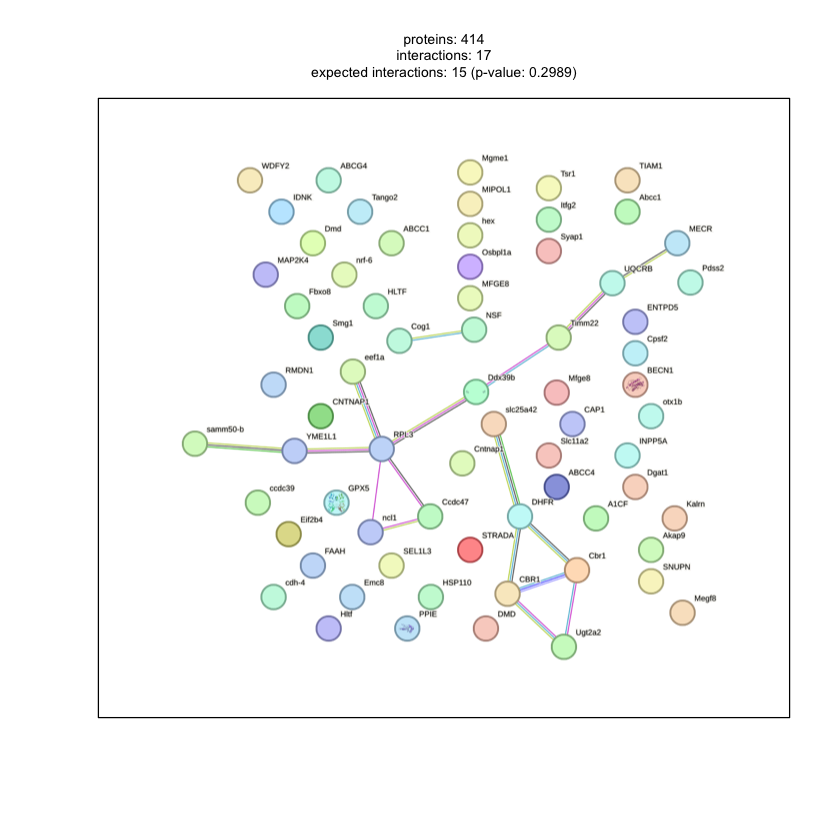

In [171]:
string_db$plot_network(skyblue_mapped)

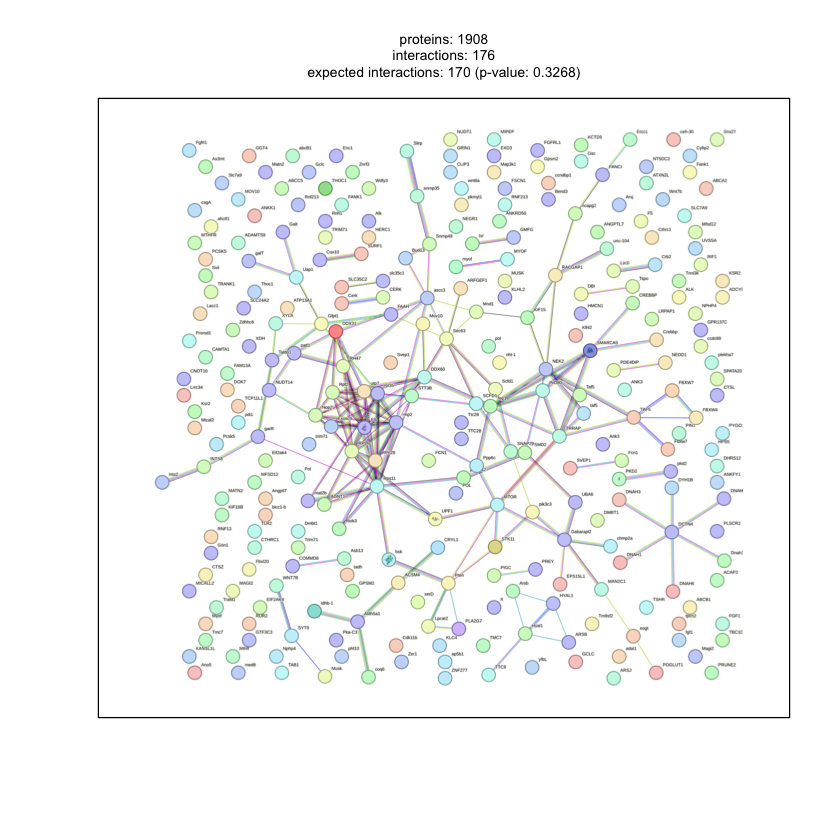

In [172]:
string_db$plot_network(pink_mapped)

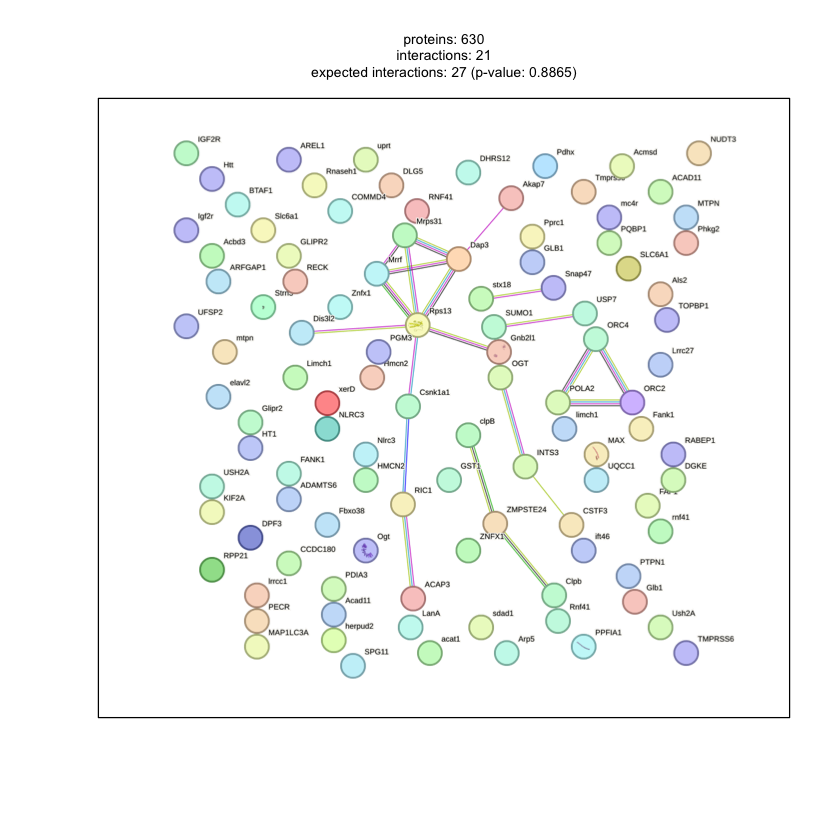

In [173]:
string_db$plot_network(royalblue_mapped)

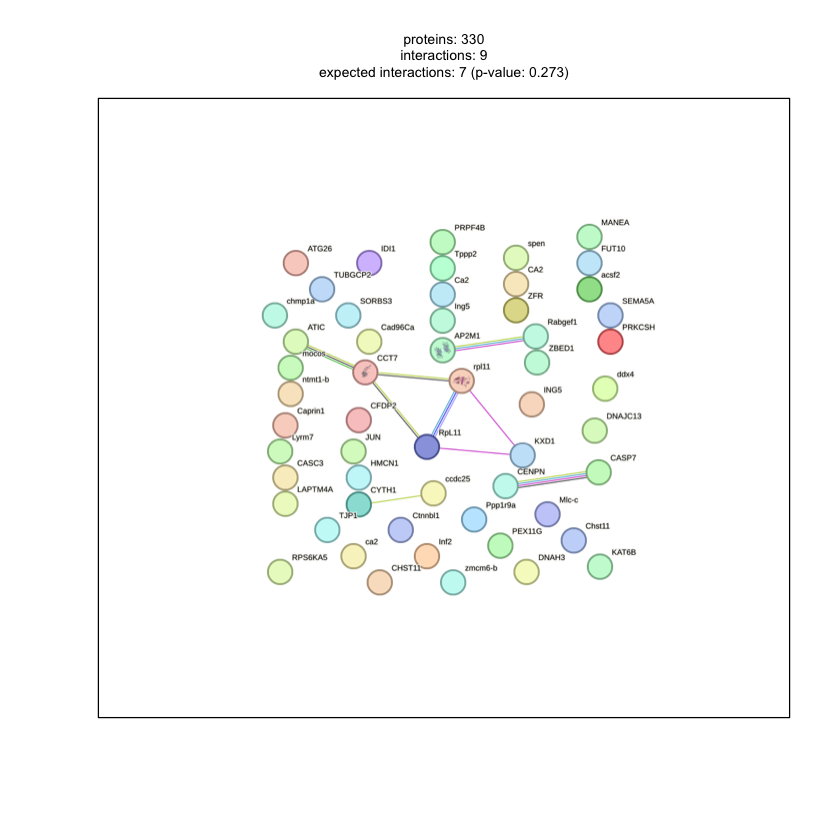

In [174]:
string_db$plot_network(steelblue_mapped)

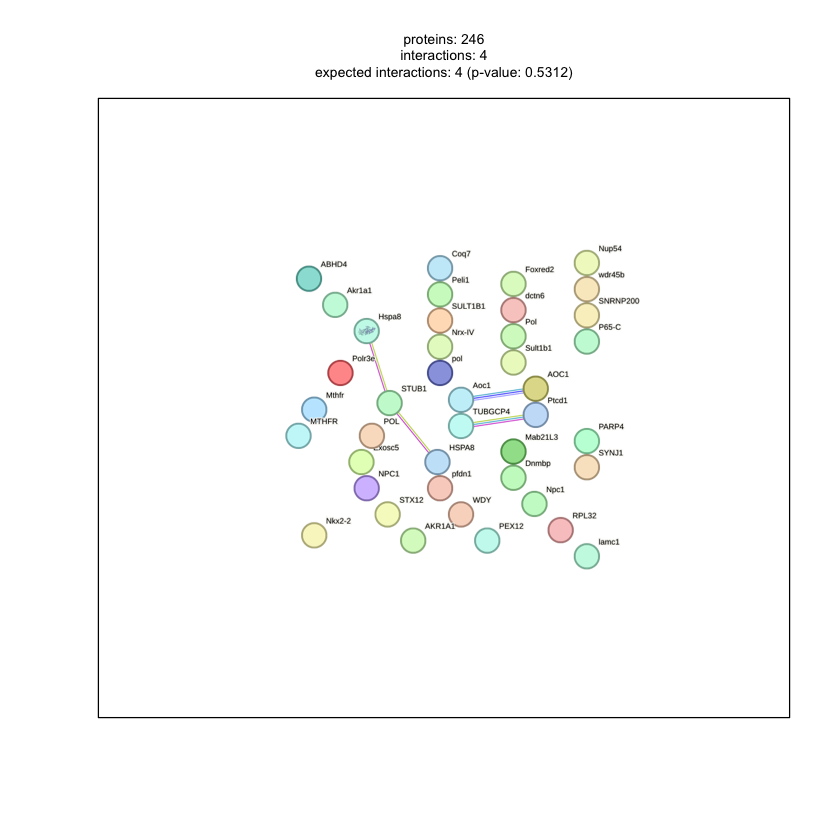

In [175]:
string_db$plot_network(violet_mapped)

In [176]:
string_db$plot_network(green_mapped)

ERROR: Error in readPNG(postFormSmart(urlStr, .params = params, .ctype = "raw")): libpng error: Not a PNG file


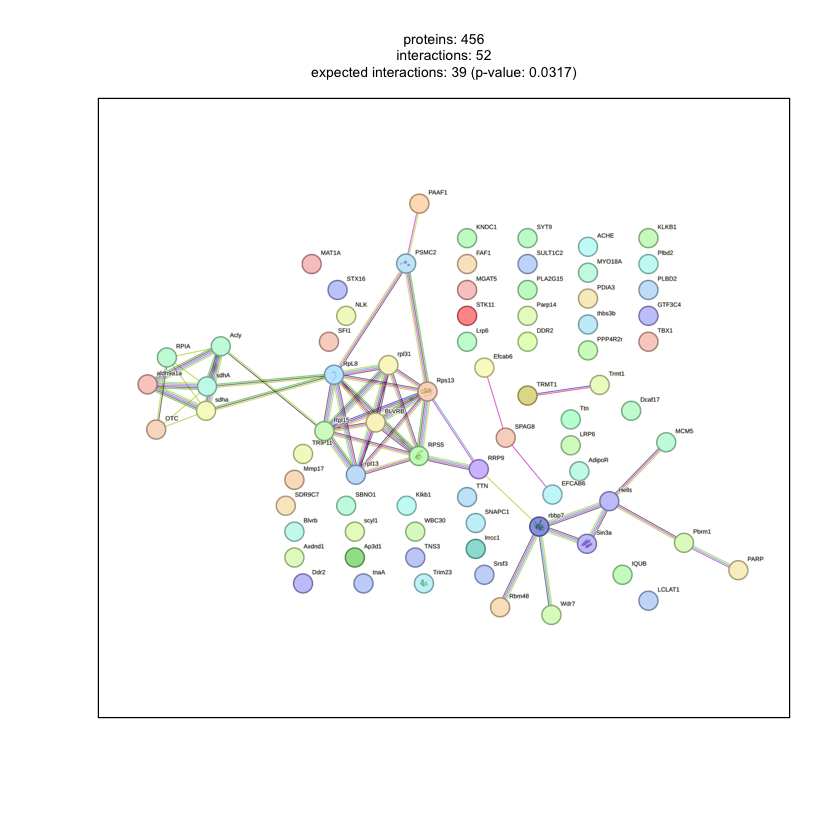

In [177]:
string_db$plot_network(white_mapped)

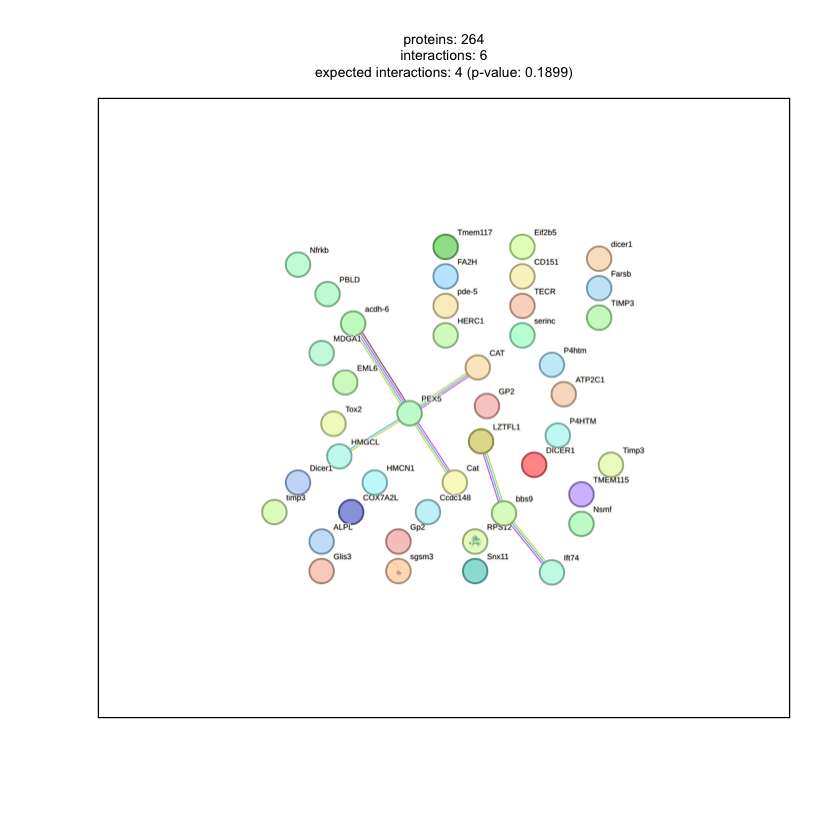

In [178]:
string_db$plot_network(darkmagenta_mapped)

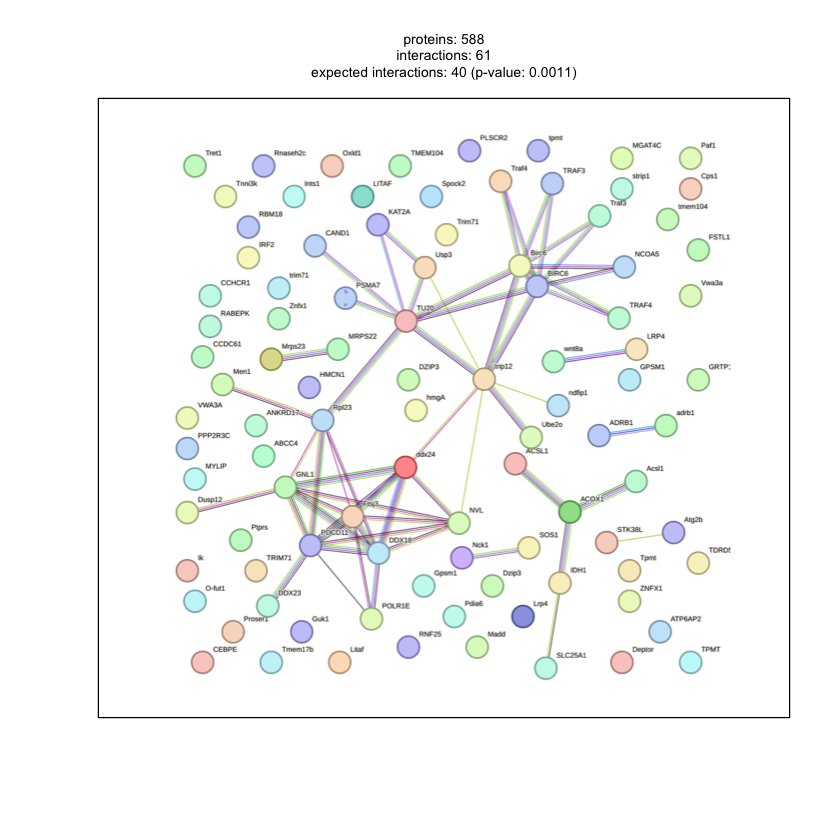

In [179]:
string_db$plot_network(darkred_mapped)

In [180]:
string_db$plot_network(turquoise_mapped)

ERROR: Error in readPNG(postFormSmart(urlStr, .params = params, .ctype = "raw")): libpng error: Not a PNG file


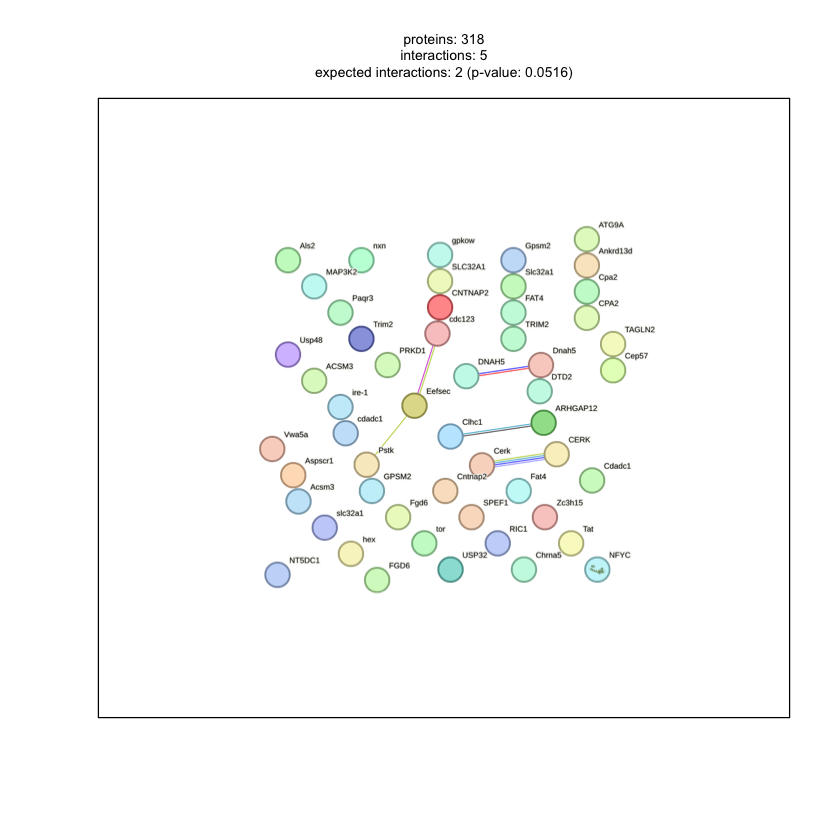

In [181]:
string_db$plot_network(sienna3_mapped)

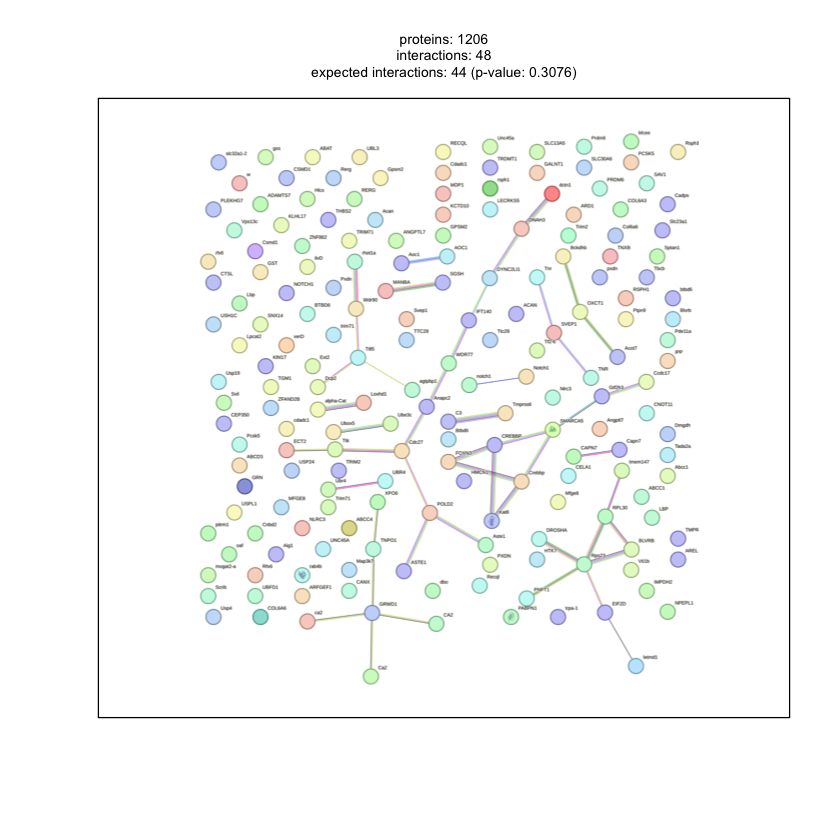

In [182]:
string_db$plot_network(salmon_mapped)

After plotting, we filter the mapping results to only significant (p < 0.5) mappings.

In [183]:
skyblue_mapped_pval05 <- string_db$add_diff_exp_color(subset(skyblue_mapped, p.MM.skyblue < 0.05),
                                                      logFcColStr="MM.skyblue" )

In [184]:
pink_mapped_pval05 <- string_db$add_diff_exp_color(subset(pink_mapped, p.MM.pink < 0.05),
                                                   logFcColStr="MM.pink" )

In [185]:
royalblue_mapped_pval05 <- string_db$add_diff_exp_color(subset(royalblue_mapped, p.MM.royalblue < 0.05),
                                                   logFcColStr="MM.royalblue" )

In [186]:
steelblue_mapped_pval05 <- string_db$add_diff_exp_color(subset(steelblue_mapped, p.MM.steelblue < 0.05),
                                                   logFcColStr="MM.steelblue" )

In [187]:
violet_mapped_pval05 <- string_db$add_diff_exp_color(subset(violet_mapped, p.MM.violet < 0.05),
                                                        logFcColStr="MM.violet" )

In [188]:
green_mapped_pval05 <- string_db$add_diff_exp_color(subset(green_mapped, p.MM.green < 0.05),
                                                     logFcColStr="MM.green" )

In [189]:
white_mapped_pval05 <- string_db$add_diff_exp_color(subset(white_mapped, p.MM.white < 0.05),
                                                    logFcColStr="MM.white" )

In [190]:
darkmagenta_mapped_pval05 <- string_db$add_diff_exp_color(subset(darkmagenta_mapped, p.MM.darkmagenta < 0.05),
                                                    logFcColStr="MM.darkmagenta" )

In [191]:
darkred_mapped_pval05 <- string_db$add_diff_exp_color(subset(darkred_mapped, p.MM.darkred < 0.05),
                                                          logFcColStr="MM.darkred" )

In [192]:
turquoise_mapped_pval05 <- string_db$add_diff_exp_color(subset(turquoise_mapped, p.MM.turquoise < 0.05),
                                                      logFcColStr="MM.turquoise" )

In [193]:
sienna3_mapped_pval05 <- string_db$add_diff_exp_color(subset(sienna3_mapped, p.MM.sienna3 < 0.05),
                                                        logFcColStr="MM.sienna3" )

In [194]:
salmon_mapped_pval05 <- string_db$add_diff_exp_color(subset(salmon_mapped, p.MM.salmon < 0.05),
                                                      logFcColStr="MM.salmon" )

Calculate enrichment for each module by hypergeometric test.

In [196]:
skyblue_enrichment <- string_db$get_enrichment(skyblue_mapped_pval05)

In [197]:
pink_enrichment <- string_db$get_enrichment(pink_mapped_pval05)

In [198]:
royalblue_enrichment <- string_db$get_enrichment(royalblue_mapped_pval05)

In [199]:
steelblue_enrichment <- string_db$get_enrichment(steelblue_mapped_pval05)

In [200]:
violet_enrichment <- string_db$get_enrichment(violet_mapped_pval05)

In [201]:
green_enrichment <- string_db$get_enrichment(green_mapped_pval05)

In [202]:
white_enrichment <- string_db$get_enrichment(white_mapped_pval05)

In [203]:
darkmagenta_enrichment <- string_db$get_enrichment(darkmagenta_mapped_pval05)

In [204]:
darkred_enrichment <- string_db$get_enrichment(darkred_mapped_pval05)

In [205]:
turquoise_enrichment <- string_db$get_enrichment(turquoise_mapped_pval05)

In [206]:
sienna3_enrichment <- string_db$get_enrichment(sienna3_mapped_pval05)

In [207]:
salmon_enrichment <- string_db$get_enrichment(salmon_mapped_pval05)

Once we have all of the enrichment data, we add a column to each of the enrichment dataframes and then merge them into a single dataframe for plotting.

In [208]:
skyblue_enrichment$module <- "skyblue"
pink_enrichment$module <- "pink"
royalblue_enrichment$module <- "royalblue"
steelblue_enrichment$module <- "steelblue"
violet_enrichment$module <- "violet"
green_enrichment$module <- "green"
white_enrichment$module <- "white"
darkmagenta_enrichment$module <- "darkmagenta"
darkred_enrichment$module <- "darkred"
turquoise_enrichment$module <- "turquoise"
sienna3_enrichment$module <- "sienna3"
salmon_enrichment$module <- "salmon"

In [294]:
merged_enrichment <- rbind(skyblue_enrichment,pink_enrichment,royalblue_enrichment,steelblue_enrichment,violet_enrichment,
                           green_enrichment,white_enrichment,darkmagenta_enrichment,darkred_enrichment,turquoise_enrichment,
                           sienna3_enrichment,salmon_enrichment)

Next, we export the merged enrichment table and added a column of broad functional groups for each of the enrichment terms and imported the updated table.

In [295]:
write.csv(merged_enrichment, "merged_enrichment.csv", row.names = FALSE)
merged_enrichment <- read.csv("merged_enrichment_groups.csv")

After importing the new file with the broad groups included, we filtered to only enrichment groups of interest (GO terms and KEGG pathways).

In [296]:
merged_enrichment_filtered <- subset(merged_enrichment, category %in% c("Process","Function","KEGG"))

Next we isolated the enrichment terms unique to pathogen response, probiotic response, or shared bacterial response and made a single dataframe of unique enrichment terms for each response.

In [297]:
bac_response <- subset(merged_enrichment_filtered, module %in% c("salmon","sienna3","turquoise"))
path_response <- subset(merged_enrichment_filtered, module %in% c("darkred","darkmagenta","skyblue"))
pro_response <- subset(merged_enrichment_filtered, module %in% c("white","green","violet","steelblue","royalblue","pink"))

In [298]:
bac_response_unique <- subset(bac_response, !(description %in% c(path_response$description,pro_response$description)))
path_response_unique <- subset(path_response, !(description %in% c(bac_response$description,pro_response$description)))
pro_response_unique <- subset(pro_response, !(description %in% c(bac_response$description,path_response$description)))

In [299]:
unique_enrichment <- rbind(bac_response_unique,path_response_unique,pro_response_unique)

We then filtered to the functional groups we were most interested in and reordered the modules to the order we wanted them to plot in.

In [300]:
unique_enrichment_filtered <- subset(unique_enrichment, group %in% c("ciliary action",
                                                                     "immune",
                                                                     "metabolism",
                                                                     "signaling",
                                                                     "transport",
                                                                     "cell cycle",
                                                                     "development"))

In [301]:
unique_enrichment_filtered$module <- factor(unique_enrichment_filtered$module, levels = c("salmon",
                                                                                          "sienna3",
                                                                                          "turquoise",
                                                                                          "darkred",
                                                                                          "darkmagenta",
                                                                                          "white",
                                                                                          "green",
                                                                                          "violet",
                                                                                          "steelblue",
                                                                                          "royalblue",
                                                                                          "pink",
                                                                                          "skyblue"))

For intial plotting, we used the full enrichment dataset and started by ordering the modules to the order we want them plotted in. We then added a cluster column to the dataframe where the clusters represent the response group those modules correlate to (i.e. pathogen response, probiotic response, shared response to bacteria. Those clusters were then sorted into the order we wanted them to plot in. We used these ordering commands to ensure we could align multiple plots later on in the script.

In [302]:
merged_enrichment_filtered$module <- factor(merged_enrichment_filtered$module, levels = c("salmon",
                                                                                          "sienna3",
                                                                                          "turquoise",
                                                                                          "darkred",
                                                                                          "darkmagenta",
                                                                                          "white",
                                                                                          "green",
                                                                                          "violet",
                                                                                          "steelblue",
                                                                                          "royalblue",
                                                                                          "pink",
                                                                                          "skyblue"))

In [304]:
merged_enrichment_filtered <- merged_enrichment_filtered %>% mutate(cluster = case_when(module == "salmon" ~ "cluster1",
                                                                                        module == "sienna3" ~ "cluster1",
                                                                                        module == "turquoise" ~ "cluster1",
                                                                                        module == "darkred" ~ "cluster2",
                                                                                        module == "darkmagenta" ~ "cluster2",
                                                                                        module == "white" ~ "cluster3",
                                                                                        module == "green" ~ "cluster3",
                                                                                        module == "violet" ~ "cluster3",
                                                                                        module == "steelblue" ~ "cluster3",
                                                                                        module == "royalblue" ~ "cluster3",
                                                                                        module == "pink" ~ "cluster3",
                                                                                        module == "skyblue" ~ "cluster4"))

merged_enrichment_filtered$cluster <- factor(merged_enrichment_filtered$cluster, levels = c("cluster4","cluster2",
                                                                                            "cluster3","cluster1"))

Here, we plot the stacked barplot showing the functional categories that were enriched in each module and how many transcripts belonged to each of those categories in the modules.

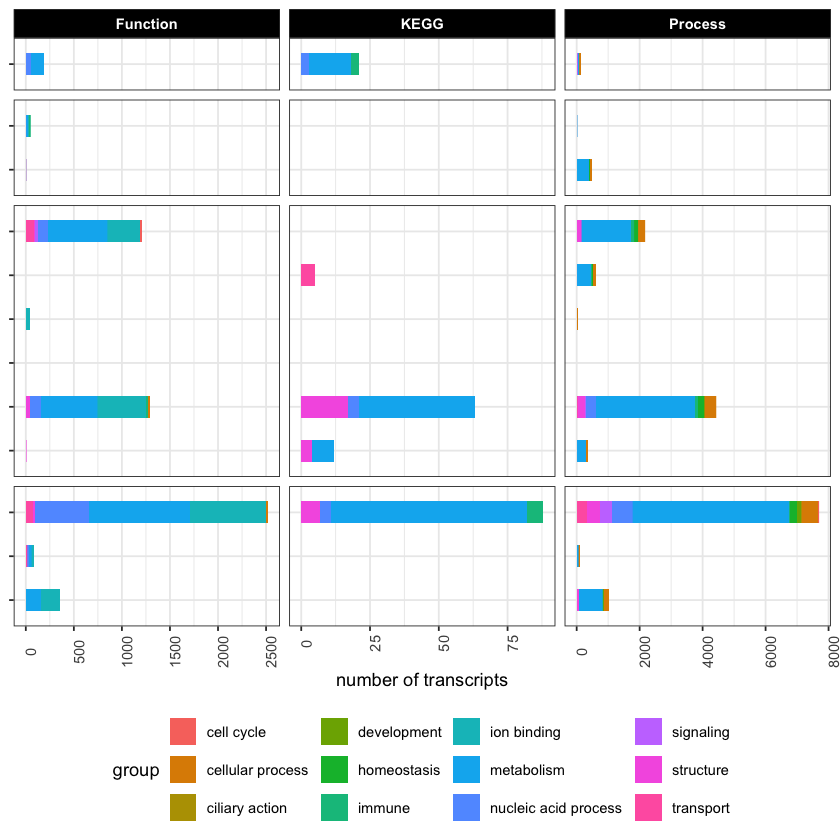

In [317]:
stacked_barplot <- ggplot(merged_enrichment_filtered, aes(module, number_of_genes, fill = group)) + 
  geom_bar(stat = "identity", width = 0.5) + facet_grid(cluster~category, scales = "free", space = "free_y") + 
  theme_bw() + theme(axis.text.x = element_text(angle = 90)) + theme(legend.position = "bottom") +
  theme(strip.background.y = element_blank(), strip.text.y = element_blank()) +
  theme(axis.title.y = element_blank(), axis.text.y = element_blank()) +
  theme(legend.position = "bottom") +
  theme(strip.background = element_rect(fill = "black"), strip.text = element_text(color = "white", face = "bold")) +
  ylab("number of transcripts") + coord_flip()
stacked_barplot

In this last step, we merged the clean heatmap from above with the stacked barplot to look at enrichment and correlation to treatments in a single figure.

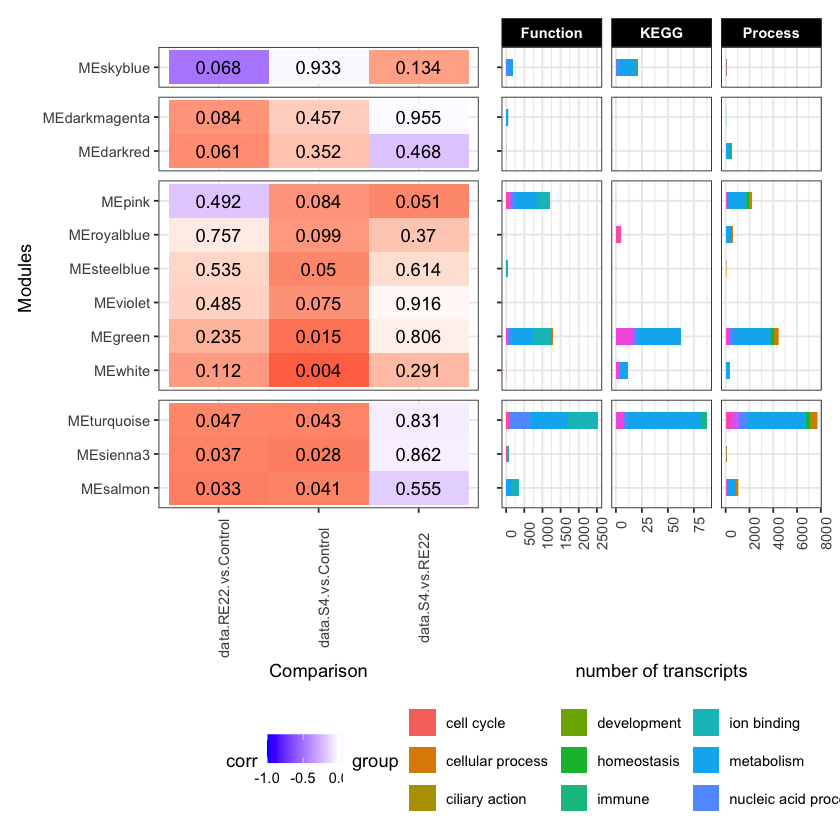

In [318]:
merged_fig <- clean_heatmap * stacked_barplot
merged_fig

In [ ]:
ggsave("~/Desktop/WGCNA_merged_fig.pdf", merged_fig, height = 7, width = 8)

<a id=13 ></a>
## 13. Enrichment by functional category plots
Here we use bubble plots to plot the unique enrichment terms for each module in the functional categories of interest to us (i.e. immune, development, ciliary action, cell cycle, metabolism, transport). In each of these graphs, the enrichment terms are on the y axis, the comparison are on the x axis. 

*Immune*

In [339]:
immune_data <- subset(unique_enrichment_filtered, group == "immune")

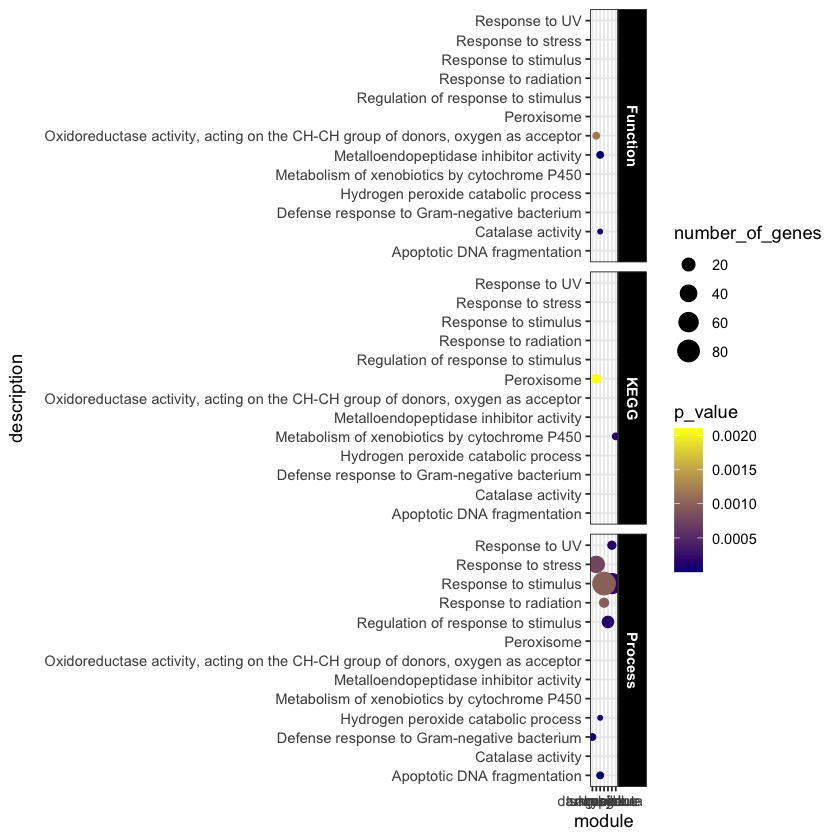

In [340]:
immune_plot <- ggplot(immune_data, aes(module, description, size = number_of_genes, color = p_value)) +
               geom_point() + facet_grid(category~group, space = "free_x") +
               theme_bw() + theme(strip.text.x = element_blank(), strip.background = element_rect(fill = "black")) +
               theme(strip.text = element_text(color = "white", face = "bold")) +
               scale_color_gradient(high = "yellow", low = "navy")
immune_plot

*Metabolism*

In [341]:
metabolism_data <- subset(unique_enrichment_filtered, group == "metabolism")

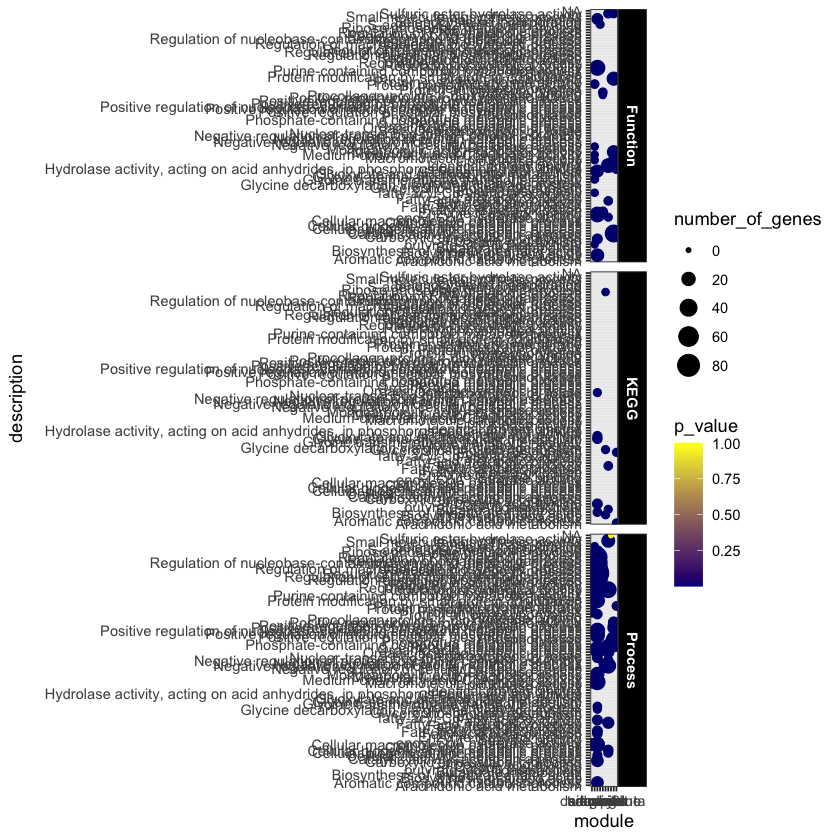

In [342]:
metabolism_plot <- ggplot(metabolism_data, aes(module, description, size = number_of_genes, color = p_value)) +
               geom_point() + facet_grid(category~group, space = "free_x") +
               theme_bw() + theme(strip.text.x = element_blank(), strip.background = element_rect(fill = "black")) +
               theme(strip.text = element_text(color = "white", face = "bold")) +
               scale_color_gradient(high = "yellow", low = "navy")
metabolism_plot

*Transport*

In [343]:
transport_data <- subset(unique_enrichment_filtered, group == "transport")

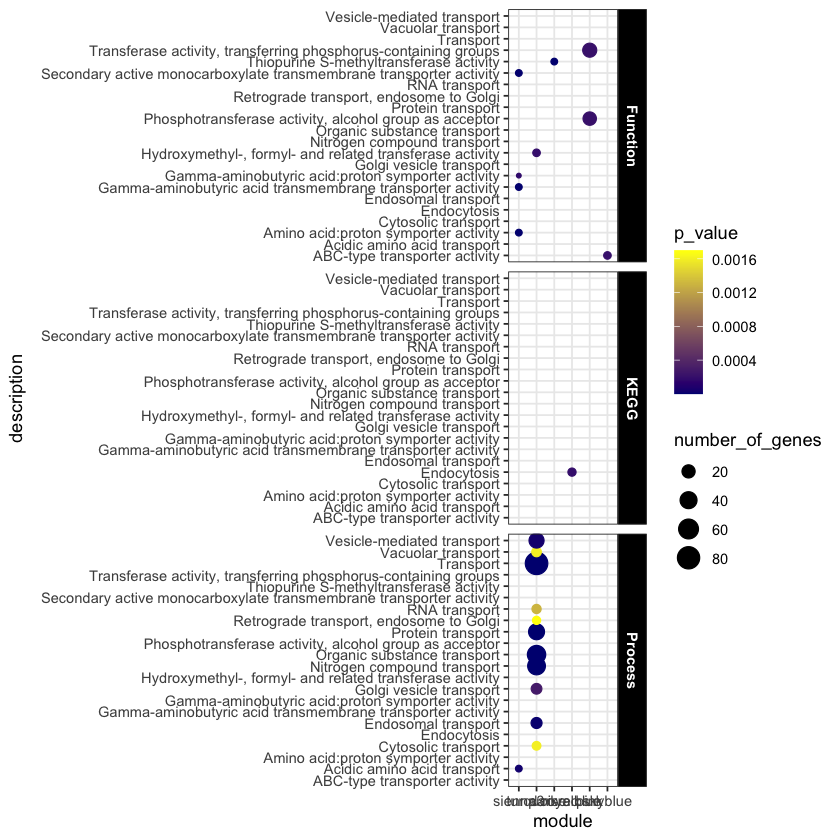

In [344]:
transport_plot <- ggplot(transport_data, aes(module, description, size = number_of_genes, color = p_value)) +
               geom_point() + facet_grid(category~group, space = "free_x") +
               theme_bw() + theme(strip.text.x = element_blank(), strip.background = element_rect(fill = "black")) +
               theme(strip.text = element_text(color = "white", face = "bold")) +
               scale_color_gradient(high = "yellow", low = "navy")
transport_plot

*Cell cycle*

In [345]:
cellcycle_data <- subset(unique_enrichment_filtered, group == "cell cycle")

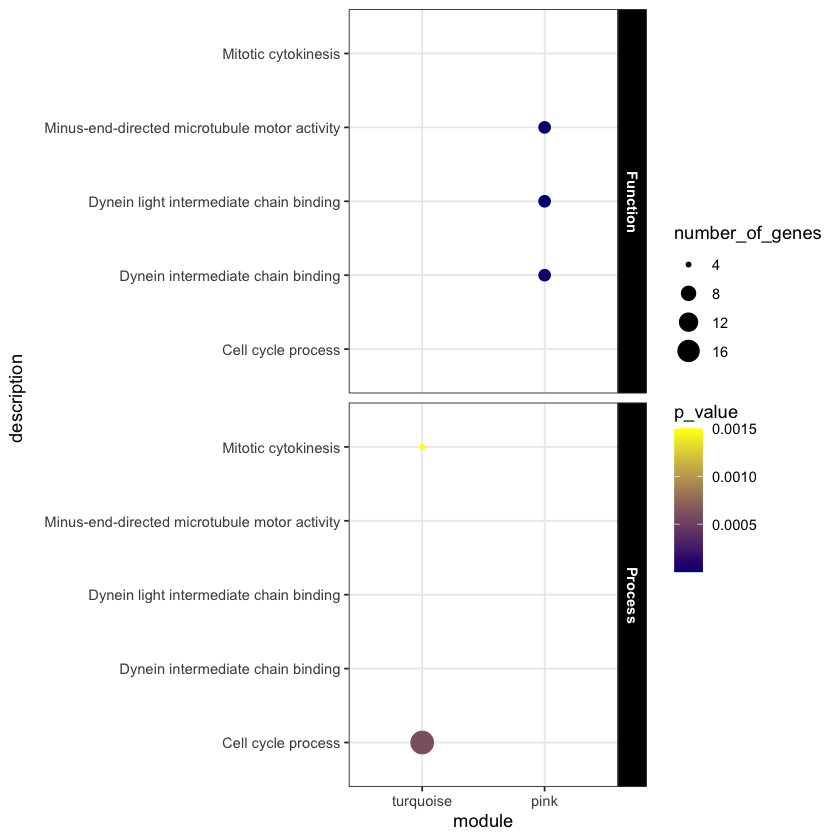

In [346]:
cellcycle_plot <- ggplot(cellcycle_data, aes(module, description, size = number_of_genes, color = p_value)) +
               geom_point() + facet_grid(category~group, space = "free_x") +
               theme_bw() + theme(strip.text.x = element_blank(), strip.background = element_rect(fill = "black")) +
               theme(strip.text = element_text(color = "white", face = "bold")) +
               scale_color_gradient(high = "yellow", low = "navy")
cellcycle_plot

*Ciliary action*

In [347]:
ciliary_data <- subset(unique_enrichment_filtered, group == "ciliary action")

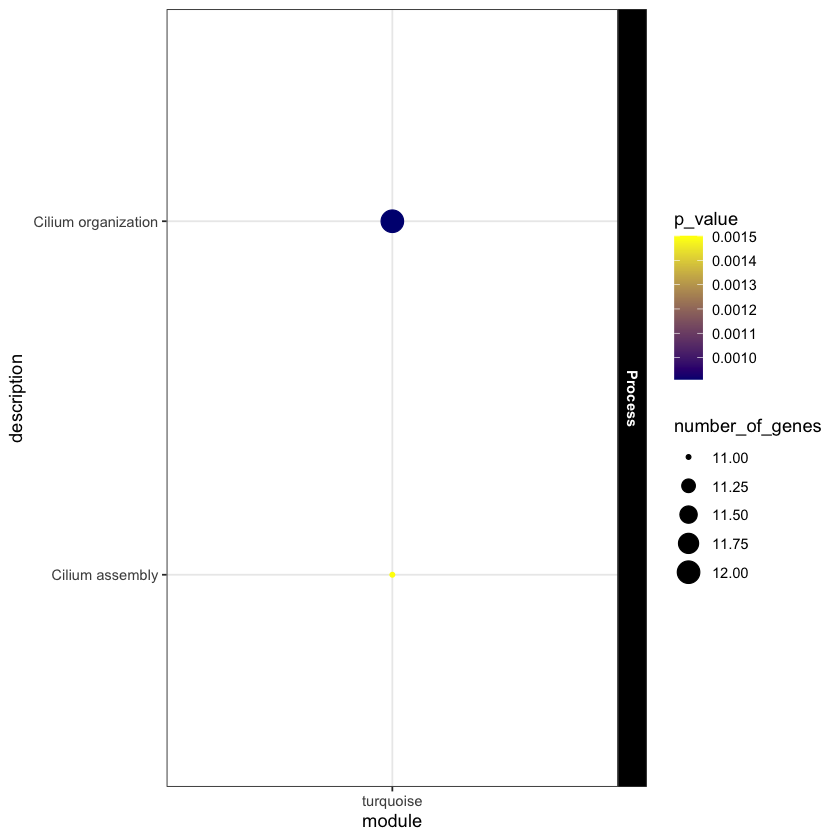

In [348]:
ciliary_plot <- ggplot(ciliary_data, aes(module, description, size = number_of_genes, color = p_value)) +
               geom_point() + facet_grid(category~group, space = "free_x") +
               theme_bw() + theme(strip.text.x = element_blank(), strip.background = element_rect(fill = "black")) +
               theme(strip.text = element_text(color = "white", face = "bold")) +
               scale_color_gradient(high = "yellow", low = "navy")
ciliary_plot

*Development*

In [349]:
development_data <- subset(unique_enrichment_filtered, group == "development")

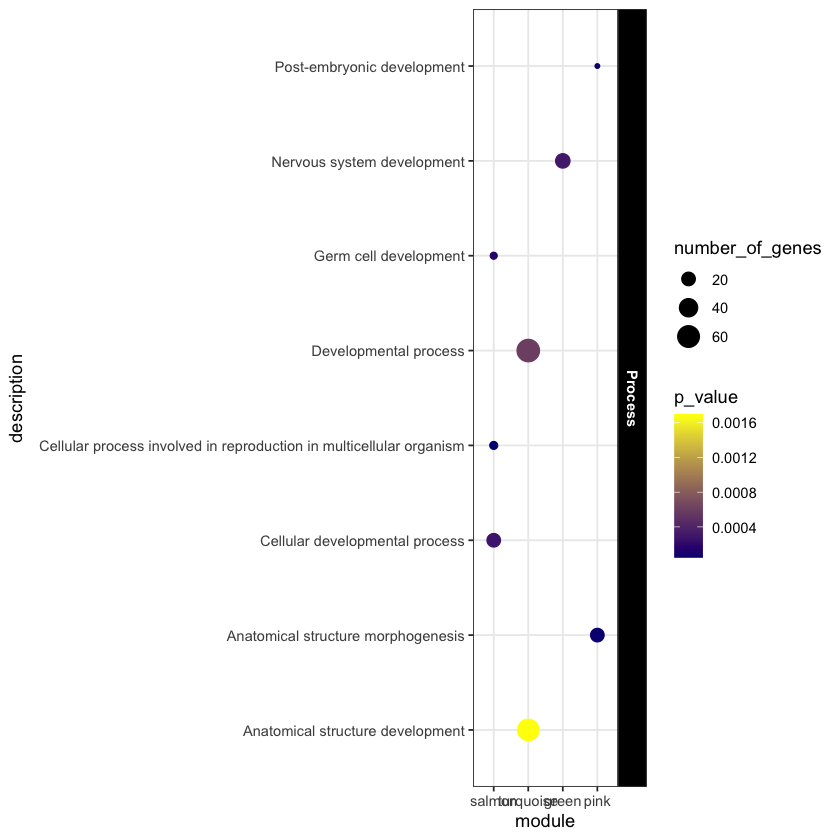

In [350]:
development_plot <- ggplot(development_data, aes(module, description, size = number_of_genes, color = p_value)) +
               geom_point() + facet_grid(category~group, space = "free_x") +
               theme_bw() + theme(strip.text.x = element_blank(), strip.background = element_rect(fill = "black")) +
               theme(strip.text = element_text(color = "white", face = "bold")) +
               scale_color_gradient(high = "yellow", low = "navy")
development_plot

<a id=14></a>
## 14. Enrichment summary figure
The final step in this analysis was to build a summary figure of what types of processes were present and absent from the unique enrichment results for each module. We used broad categories to group the processes and simply used a square to indicate what modules those processes were present in.

We start by importing the enrichment summary data table and then adding a cluster column to match the clusters from the previous graphs. 

In [351]:
summary_data <- read.csv("enrichment_summary.csv")
head(summary_data)

category  group             module      value
1 transport protein transport salmon      0    
2 transport protein transport sienna3     1    
3 transport protein transport turquoise   1    
4 transport protein transport darkred     0    
5 transport protein transport darkmagenta 0    
6 transport protein transport skyblue     0

In [358]:
summary_data <- summary_data %>% mutate(cluster = case_when(module == "salmon" ~ "cluster1",
                                                            module == "sienna3" ~ "cluster1",
                                                            module == "turquoise" ~ "cluster1",
                                                            module == "darkred" ~ "cluster2",
                                                            module == "darkmagenta" ~ "cluster2",
                                                            module == "white" ~ "cluster3",
                                                            module == "green" ~ "cluster3",
                                                            module == "violet" ~ "cluster3",
                                                            module == "steelblue" ~ "cluster3",
                                                            module == "royalblue" ~ "cluster3",
                                                            module == "pink" ~ "cluster3",
                                                            module == "skyblue" ~ "cluster4"))

summary_data$cluster <- factor(summary_data$cluster, levels = c("cluster4","cluster2",
                                                                "cluster3","cluster1"))

Next, we filter to only present data (in other word filter out any row that has zero in the value column).

In [367]:
summary_data_filtered <- subset(summary_data, value != 0)

Finally, we plot the summary figure and export with `ggsave()`. All final edits were made using Adobe Illustrator to prepare figure for publication.

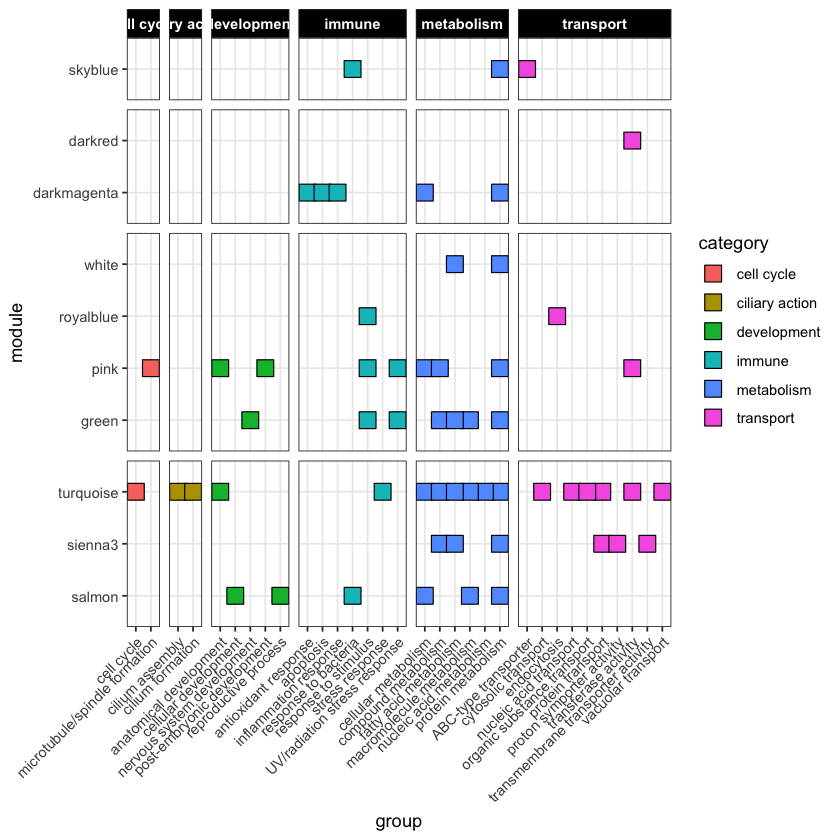

In [382]:
summary_plot <- ggplot(summary_data_filtered, aes(group, module, fill = category)) + 
                geom_point(pch = 22, size = 5) +
                facet_grid(cluster~category, space = "free", scale = "free") +
                theme_bw() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
                theme(strip.background.y = element_blank(), strip.text.y = element_blank()) +
                theme(strip.background.x = element_rect(fill = "black"), 
                      strip.text.x = element_text(color = "white", face = "bold"))
summary_plot

In [383]:
ggsave("~/Desktop/enrichment_summary_fig.pdf",summary_plot, height = 6, width = 10)